# Transfer Learning su CNN per embedding di Facce
Modifica di una CNN generale (ResNet) che presa un immagine in input la trasforma in un Embedding <br>
Obiettivo: faccie simili avranno vettori simili. <br>
Questo modello verrá usato nell'app di Riconoscimento Facciale per il Progetto di DeepLearning e Architetture di Reti Nurali UniBs 2025/2026

Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm
import os
import json
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
import numpy as np
import zipfile
import shutil
from torchvision import models

# Download and Load Dataset functions

In [2]:
def get_data_transforms(img_size=128, augment=True):
    """
    Crea le trasformazioni per train e test

    Args:
        img_size: dimensione output immagini
        augment: se True, applica data augmentation al training set

    Returns:
        train_transform, test_transform
    """
    # Trasformazioni base per test (solo resize e normalizzazione)
    test_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    # Trasformazioni per training con augmentation
    if augment:
        train_transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])
    else:
        train_transform = test_transform

    return train_transform, test_transform


In [3]:
def load_lfw_with_sklearn(data_dir='./content/data', min_faces_per_person=10):
    """
    Scarica LFW usando sklearn (metodo più affidabile)

    Args:
        data_dir: directory dove salvare il dataset
        min_faces_per_person: minimo immagini per persona

    Returns:
        images (numpy array), labels (numpy array), num_classes
    """
    print("Download LFW con sklearn...")
    lfw_people = fetch_lfw_people(
        data_home=data_dir,
        min_faces_per_person=min_faces_per_person,
        resize=1.0,  # mantiene dimensione originale
        color=True
    )

    images = lfw_people.images  # shape: (n_samples, height, width, 3)
    labels = lfw_people.target
    num_classes = len(lfw_people.target_names)

    print(f"Dataset scaricato:")
    print(f"  Totale samples: {len(images)}")
    print(f"  Dimensione immagini: {images[0].shape}")
    print(f"  Num classes: {num_classes}")

    return images, labels, num_classes


class LFWDataset(Dataset):
    """
    Custom Dataset per LFW da array numpy
    """
    def __init__(self, images, labels, transform=None):
        """
        Args:
            images: numpy array (n_samples, height, width, 3)
            labels: numpy array (n_samples,)
            transform: trasformazioni da applicare
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Converti numpy array a PIL Image
        image = self.images[idx]
        # Assicurati che i valori siano in [0, 255]
        if image.max() <= 1.0:
            image = (image * 255).astype(np.uint8)
        image = Image.fromarray(image)

        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


def load_lfw_dataset(data_dir='./content/data', img_size=128, batch_size=64,
                     augment=True, min_faces_per_person=10, test_split=0.2):
    """
    Carica il dataset LFW usando sklearn

    Args:
        data_dir: directory dove salvare/caricare il dataset
        img_size: dimensione immagini
        batch_size: batch size per DataLoader
        augment: se True, applica data augmentation
        min_faces_per_person: minimo immagini per persona da includere
        test_split: percentuale per test set (es. 0.2 = 20%)

    Returns:
        train_loader, test_loader, num_classes
    """
    # Scarica dataset con sklearn
    images, labels, num_classes = load_lfw_with_sklearn(data_dir, min_faces_per_person)

    train_transform, test_transform = get_data_transforms(img_size, augment)

    # Split train/test stratificato
    train_images, test_images, train_labels, test_labels = train_test_split(
        images, labels,
        test_size=test_split,
        stratify=labels,
        random_state=42
    )

    # Crea dataset con trasformazioni appropriate
    train_dataset = LFWDataset(train_images, train_labels, train_transform)
    test_dataset = LFWDataset(test_images, test_labels, test_transform)

    # DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    print(f"\nDataLoaders creati:")
    print(f"  Train samples: {len(train_dataset)}")
    print(f"  Test samples: {len(test_dataset)}")
    print(f"  Batch size: {batch_size}")

    return train_loader, test_loader, num_classes

# Creazione classi:
- FaceEmbeddingCNN come classe principale
- ResidualBlcok per avere un NiN


In [4]:
class ResidualBlock(nn.Module):
    """
    Blocco residuale per CNN
    Conv → BN → ReLU → Conv → BN → (+skip) → ReLU
    """
    def __init__(self, in_channels, out_channels, kernel_size=3,
                 dropout_rate=0.5, use_batchnorm=True):
        super(ResidualBlock, self).__init__()

        padding = kernel_size // 2

        # Prima convoluzione
        self.conv1 = nn.Conv2d(in_channels, out_channels,
                              kernel_size=kernel_size, padding=padding)
        self.bn1 = nn.BatchNorm2d(out_channels) if use_batchnorm else nn.Identity()
        self.relu1 = nn.ReLU()

        # Seconda convoluzione
        self.conv2 = nn.Conv2d(out_channels, out_channels,
                              kernel_size=kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm2d(out_channels) if use_batchnorm else nn.Identity()

        # Projection shortcut se dimensioni diverse
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels) if use_batchnorm else nn.Identity()
            )
        else:
            self.shortcut = nn.Identity()

        self.relu2 = nn.ReLU()
        self.dropout = nn.Dropout2d(dropout_rate) if dropout_rate > 0 else nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # Skip connection
        out = out + identity
        out = self.relu2(out)
        out = self.dropout(out)

        return out

In [5]:
class TransferLearningEmbeddingCNN(nn.Module):
    """
    Convolutional Neural Network per generare embeddings di volti.
    Durante training: classificazione delle identità (cross entropy)
    Durante inference: estrazione embedding dal penultimo layer

    Supporta sia CNN standard che CNN con residual connections (ResNet-style)
    """

    def __init__(self,
                 input_channels=3,  # RGB
                 num_filters=[32, 64, 128],  # filtri per ogni conv block
                 kernel_sizes=[3, 3, 3],  # kernel size per ogni conv block
                 fc_hidden_size=512,  # dimensione layer fully connected
                 embedding_size=128,  # dimensione embedding finale
                 num_classes=5749,  # numero identità
                 dropout_rate=0.5,  # dropout rate
                 use_batchnorm=True,  # usa batch normalization
                 use_global_avg_pool=False,  # usa global average pooling
                 use_residual=False,  # usa residual connections (skip connections)
                 use_pretrained_resnet=False,  # <se usare il transferlearning con resnet
                 resnet_version='resnet18',    # versione resnet usata
                 freeze_resnet_backbone=False): # per freezzare il backbone o no
        """
        Args:
            input_channels: numero canali input (3 per RGB)
            num_filters: lista con numero filtri per ogni conv block
            kernel_sizes: lista con kernel size per ogni conv block
            fc_hidden_size: dimensione layer fully connected dopo conv
            embedding_size: dimensione del vettore embedding
            num_classes: numero di identità (classi) per classificazione
            dropout_rate: probabilità dropout (0 = no dropout)
            use_batchnorm: se True, aggiunge BatchNorm dopo ogni conv
            use_global_avg_pool: se True, usa GAP invece di flatten
            use_residual: se True, usa residual blocks con skip connections
        """
        super(TransferLearningEmbeddingCNN, self).__init__()

        self.embedding_size = embedding_size
        self.use_batchnorm = use_batchnorm
        self.use_global_avg_pool = use_global_avg_pool
        self.use_residual = use_residual

        # Costruzione convolutional blocks
        if use_pretrained_resnet:
            # === TRANSFER LEARNING: ResNet pre-trained ===
            if resnet_version == 'resnet18':
                backbone = models.resnet18(pretrained=True)
                backbone_output_channels = 512
            elif resnet_version == 'resnet34':
                backbone = models.resnet34(pretrained=True)
                backbone_output_channels = 512
            elif resnet_version == 'resnet50':
                backbone = models.resnet50(pretrained=True)
                backbone_output_channels = 2048
            else:
                raise ValueError("resnet_version deve essere 'resnet18', 'resnet34' o 'resnet50'")
            
            # Togli avgpool + fc finale
            self.backbone = nn.Sequential(*list(backbone.children())[:-2])
            
            # Congela se richiesto
            if freeze_resnet_backbone:
                for param in self.backbone.parameters():
                    param.requires_grad = False
            
            # Aggiungo i miei residual blocks dopo ResNet
            residual_layers = []
            in_channels = backbone_output_channels
            
            for num_filter, kernel_size in zip(num_filters, kernel_sizes):
                residual_layers.append(ResidualBlock(
                    in_channels,
                    num_filter,
                    kernel_size=kernel_size,
                    dropout_rate=dropout_rate,
                    use_batchnorm=use_batchnorm
                ))
                in_channels = num_filter
            
            self.conv_blocks = nn.Sequential(*residual_layers)
            
        elif use_residual:
            # Residual CNN con skip connections
            conv_layers = []
            in_channels = input_channels

            for num_filter, kernel_size in zip(num_filters, kernel_sizes):
                conv_layers.append(ResidualBlock(
                    in_channels,
                    num_filter,
                    kernel_size=kernel_size,
                    dropout_rate=dropout_rate,
                    use_batchnorm=use_batchnorm
                ))
                conv_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
                in_channels = num_filter

            self.conv_blocks = nn.Sequential(*conv_layers)


        else:
            # Standard CNN senza residual connections
            conv_layers = []
            in_channels = input_channels

            for num_filter, kernel_size in zip(num_filters, kernel_sizes):
                # Conv2d
                conv_layers.append(nn.Conv2d(
                    in_channels,
                    num_filter,
                    kernel_size=kernel_size,
                    padding=kernel_size//2
                ))

                # BatchNorm2d
                if use_batchnorm:
                    conv_layers.append(nn.BatchNorm2d(num_filter))

                # Activation
                conv_layers.append(nn.ReLU())

                # MaxPool2d
                conv_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

                # Dropout2d
                if dropout_rate > 0:
                    conv_layers.append(nn.Dropout2d(dropout_rate))

                in_channels = num_filter

            self.conv_blocks = nn.Sequential(*conv_layers)

        # Calcola dimensione output dopo conv blocks
        if use_pretrained_resnet:
            # Con ResNet usa sempre global avg pool
            self.use_global_avg_pool = True
            self.global_pool = nn.AdaptiveAvgPool2d(1)
            flatten_size = num_filters[-1]
        else:
            num_conv_blocks = len(num_filters)
            spatial_size = 128 // (2 ** num_conv_blocks)
            
            if use_global_avg_pool:
                self.global_pool = nn.AdaptiveAvgPool2d(1)
                flatten_size = num_filters[-1]
            else:
                self.global_pool = None
                flatten_size = num_filters[-1] * spatial_size * spatial_size

        # Fully connected layers per embedding
        fc_layers = []

        # FC hidden layer
        fc_layers.append(nn.Linear(flatten_size, fc_hidden_size))
        if use_batchnorm:
            fc_layers.append(nn.BatchNorm1d(fc_hidden_size))
        fc_layers.append(nn.ReLU())
        fc_layers.append(nn.Dropout(dropout_rate))

        # Embedding layer (penultimo layer)
        fc_layers.append(nn.Linear(fc_hidden_size, embedding_size))
        if use_batchnorm:
            fc_layers.append(nn.BatchNorm1d(embedding_size))
        fc_layers.append(nn.ReLU())

        self.fc_blocks = nn.Sequential(*fc_layers)

        # Classification head (solo per training)
        self.classifier = nn.Linear(embedding_size, num_classes)

    def forward(self, x):
        """
        Forward pass completo per training (con classificazione)

        Args:
            x: tensor [batch_size, channels, height, width]

        Returns:
            logits: tensor [batch_size, num_classes]
        """
        # Conv blocks
        if hasattr(self, 'backbone'):
            x = self.backbone(x)
        
        # Conv blocks
        x = self.conv_blocks(x)

        if self.use_global_avg_pool:
            x = self.global_pool(x)
            x = x.view(x.size(0), -1)
        else:
            x = x.view(x.size(0), -1)

        embedding = self.fc_blocks(x)
        logits = self.classifier(embedding)
        return logits

    def get_embedding(self, x):
        """
        Estrae solo l'embedding (per inference/confronto facce)

        Args:
            x: tensor [batch_size, channels, height, width]

        Returns:
            embedding: tensor [batch_size, embedding_size]
        """
        # Conv blocks
        if hasattr(self, 'backbone'):
            x = self.backbone(x)
            
        x = self.conv_blocks(x)

        # Resto IDENTICO
        if self.use_global_avg_pool:
            x = self.global_pool(x)
            x = x.view(x.size(0), -1)
        else:
            x = x.view(x.size(0), -1)

        embedding = self.fc_blocks(x)
        return embedding


# Creazione del Modello con Iperparametri

In [6]:
# Funzione helper per creare il modello con configurazioni diverse
def create_cnn_model(config):
    """
    Factory function per creare CNN con diverse configurazioni

    Args:
        config: dict con parametri del modello

    Returns:
        model: istanza di TransferLearningEmbeddingCNN
    """
    return TransferLearningEmbeddingCNN(
        input_channels=config.get('input_channels', 3),
        num_filters=config.get('num_filters', [32, 64, 128]),
        kernel_sizes=config.get('kernel_sizes', [3, 3, 3]),
        fc_hidden_size=config.get('fc_hidden_size', 512),
        embedding_size=config.get('embedding_size', 128),
        num_classes=config.get('num_classes', 5749),
        dropout_rate=config.get('dropout_rate', 0.5),
        use_batchnorm=config.get('use_batchnorm', True),
        use_global_avg_pool=config.get('use_global_avg_pool', False),
        use_residual=config.get('use_residual', False),
        use_pretrained_resnet=config.get('use_pretrained_resnet', False),
        resnet_version=config.get('resnet_version', 'resnet18'),
        freeze_resnet_backbone=config.get('freeze_resnet_backbone', False)
    )

# Training Loop

## Support Training Functions

In [7]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    """
    Training per una singola epoca

    Args:
        model: modello da addestrare
        train_loader: DataLoader training set
        criterion: loss function
        optimizer: ottimizzatore
        device: device (cuda/cpu)

    Returns:
        avg_loss, accuracy
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc="Training")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistiche
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })

    avg_loss = running_loss / len(train_loader)
    accuracy = 100. * correct / total

    return avg_loss, accuracy


def validate(model, test_loader, criterion, device):
    """
    Validazione sul test set

    Args:
        model: modello da validare
        test_loader: DataLoader test set
        criterion: loss function
        device: device (cuda/cpu)

    Returns:
        avg_loss, accuracy
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        pbar = tqdm(test_loader, desc="Validation")
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })

    avg_loss = running_loss / len(test_loader)
    accuracy = 100. * correct / total

    return avg_loss, accuracy


def save_checkpoint(model, optimizer, config, epoch, val_acc, filepath):
    """
    Salva checkpoint del modello

    Args:
        model: modello da salvare
        optimizer: ottimizzatore
        config: configurazione modello
        epoch: epoca corrente
        val_acc: accuracy validazione
        filepath: path dove salvare
    """
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'config': config,
        'epoch': epoch,
        'val_accuracy': val_acc
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint salvato: {filepath}")


def load_checkpoint(filepath, model, optimizer=None):
    """
    Carica checkpoint del modello

    Args:
        filepath: path del checkpoint
        model: modello dove caricare i pesi
        optimizer: (opzionale) ottimizzatore dove caricare lo stato

    Returns:
        config, epoch, val_accuracy
    """
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])

    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    print(f"Checkpoint caricato: {filepath}")
    print(f"  Epoch: {checkpoint['epoch']}")
    print(f"  Val Accuracy: {checkpoint['val_accuracy']:.2f}%")

    return checkpoint['config'], checkpoint['epoch'], checkpoint['val_accuracy']



## Training Function

In [8]:
def train_model(model, config, train_loader, test_loader,
                num_epochs=10, learning_rate=1e-3,
                checkpoint_dir='./checkpoints', device=None):
    """
    Training completo del modello

    Args:
        model: modello da addestrare
        config: configurazione modello (per salvataggio)
        train_loader: DataLoader training
        test_loader: DataLoader validation
        num_epochs: numero epoche
        learning_rate: learning rate iniziale
        checkpoint_dir: directory per salvare checkpoints
        device: device (cuda/cpu), se None rileva automaticamente

    Returns:
        model, training_history
    """
    # Device setup
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    model = model.to(device)

    # Loss e optimizer
    criterion = nn.CrossEntropyLoss()
    # TRANSFER LEARNING: learning rates differenziati
    if hasattr(model, 'backbone'):
        # ResNet backbone: learning rate MOLTO basso (o congelato)
        # Nuovi layer: learning rate normale
        optimizer = optim.Adam([
            {'params': model.backbone.parameters(), 'lr': learning_rate * 0.01},  # 100x più lento
            {'params': model.conv_blocks.parameters(), 'lr': learning_rate},      # normale
            {'params': model.fc_blocks.parameters(), 'lr': learning_rate},        # normale
            {'params': model.classifier.parameters(), 'lr': learning_rate}        # normale
        ], lr=learning_rate)
        print(f"Transfer learning: backbone LR={learning_rate*0.01:.6f}, nuovi layer LR={learning_rate:.6f}")
    else:
        # CNN standard: tutto stesso learning rate
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=2
    )

    # Creazione directory checkpoints
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    best_val_acc = 0.0

    print("\n" + "="*60)
    print("INIZIO TRAINING")
    print("="*60 + "\n")

    #ciclo di training: 1 ciclo 1 epoca, 1 trainign, 1 validazione, 1 update scheduler
    #salva SE é il migliore
    #salva l'ultimo modello epr sicurezza
    #Qui possibilitá di aggiungere Early Stopping
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 60)

        # Training
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, device
        )

        # Validation
        val_loss, val_acc = validate(
            model, test_loader, criterion, device
        )

        # Update scheduler
        scheduler.step(val_acc)

        # Salva storia
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Print epoch summary
        print(f"\nEpoch {epoch+1} Summary:")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        # Salva best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_path = os.path.join(checkpoint_dir, 'best_model.pth')
            save_checkpoint(model, optimizer, config, epoch+1, val_acc, best_model_path)
            print(f"  *** Nuovo best model! Accuracy: {val_acc:.2f}% ***")

        # Salva ultimo checkpoint
        last_checkpoint_path = os.path.join(checkpoint_dir, 'last_checkpoint.pth')
        save_checkpoint(model, optimizer, config, epoch+1, val_acc, last_checkpoint_path)

    print("\n" + "="*60)
    print("TRAINING COMPLETATO")
    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
    print("="*60 + "\n")

    return model, history

### Funzione per Fine Tuning
CHE È DIVERSO DA TRANSFER <br> 
Learnin allena tutto, scongelando il backbone, ovviamente con pesi bassi

In [9]:
def unfreeze_and_finetune(model, train_loader, test_loader, 
                          num_epochs=5, learning_rate=1e-4, 
                          checkpoint_dir='./checkpoints', device=None):
    """
    Fine-tuning: scongela il backbone e allena tutto con LR molto basso
    
    Da chiamare DOPO aver allenato con backbone congelato
    """
    # Scongela backbone
    if hasattr(model, 'backbone'):
        for param in model.backbone.parameters():
            param.requires_grad = True
        print("Backbone scongelato per fine-tuning")
    
    # Allena con LR molto basso
    return train_model(model, {}, train_loader, test_loader,
                      num_epochs=num_epochs, 
                      learning_rate=learning_rate,  # es. 1e-5
                      checkpoint_dir=checkpoint_dir,
                      device=device)

## Plot history

In [10]:
def plot_training_history(history, save_path=None):
    """
    Plotta loss e accuracy durante training

    Args:
        history: dizionario con 'train_loss', 'train_acc', 'val_loss', 'val_acc'
        save_path: (opzionale) path dove salvare il grafico
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    epochs = range(1, len(history['train_loss']) + 1)

    # Plot Loss
    ax1.plot(epochs, history['train_loss'], 'b-o', label='Train Loss', linewidth=2)
    ax1.plot(epochs, history['val_loss'], 'r-o', label='Val Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # Plot Accuracy
    ax2.plot(epochs, history['train_acc'], 'b-o', label='Train Accuracy', linewidth=2)
    ax2.plot(epochs, history['val_acc'], 'r-o', label='Val Accuracy', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Grafico salvato: {save_path}")

    plt.show()

# Utilizzo Modello (vecchio not used for this)

Download LFW con sklearn...
Dataset scaricato:
  Totale samples: 4324
  Dimensione immagini: (125, 94, 3)
  Num classes: 158

DataLoaders creati:
  Train samples: 3459
  Test samples: 865
  Batch size: 64
Using device: cuda

INIZIO TRAINING


Epoch 1/10
------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.05it/s, loss=4.8073, acc=12.25%]



Epoch 1 Summary:
  Train Loss: 4.8298 | Train Acc: 7.69%
  Val Loss: 4.5497 | Val Acc: 12.25%
Checkpoint salvato: ./checkpoints/cnn_baseline/best_model.pth
  *** Nuovo best model! Accuracy: 12.25% ***
Checkpoint salvato: ./checkpoints/cnn_baseline/last_checkpoint.pth

Epoch 2/10
------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.75it/s, loss=4.7528, acc=12.25%]



Epoch 2 Summary:
  Train Loss: 4.5949 | Train Acc: 12.29%
  Val Loss: 4.4133 | Val Acc: 12.25%
Checkpoint salvato: ./checkpoints/cnn_baseline/last_checkpoint.pth

Epoch 3/10
------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.90it/s, loss=4.7159, acc=13.29%]



Epoch 3 Summary:
  Train Loss: 4.5329 | Train Acc: 12.26%
  Val Loss: 4.3306 | Val Acc: 13.29%
Checkpoint salvato: ./checkpoints/cnn_baseline/best_model.pth
  *** Nuovo best model! Accuracy: 13.29% ***
Checkpoint salvato: ./checkpoints/cnn_baseline/last_checkpoint.pth

Epoch 4/10
------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 28.84it/s, loss=4.5986, acc=14.80%]



Epoch 4 Summary:
  Train Loss: 4.4095 | Train Acc: 12.69%
  Val Loss: 4.2407 | Val Acc: 14.80%
Checkpoint salvato: ./checkpoints/cnn_baseline/best_model.pth
  *** Nuovo best model! Accuracy: 14.80% ***
Checkpoint salvato: ./checkpoints/cnn_baseline/last_checkpoint.pth

Epoch 5/10
------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 28.39it/s, loss=4.4714, acc=15.72%]



Epoch 5 Summary:
  Train Loss: 4.3314 | Train Acc: 13.04%
  Val Loss: 4.1344 | Val Acc: 15.72%
Checkpoint salvato: ./checkpoints/cnn_baseline/best_model.pth
  *** Nuovo best model! Accuracy: 15.72% ***
Checkpoint salvato: ./checkpoints/cnn_baseline/last_checkpoint.pth

Epoch 6/10
------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 28.27it/s, loss=4.2780, acc=17.23%]



Epoch 6 Summary:
  Train Loss: 4.2210 | Train Acc: 14.40%
  Val Loss: 4.0125 | Val Acc: 17.23%
Checkpoint salvato: ./checkpoints/cnn_baseline/best_model.pth
  *** Nuovo best model! Accuracy: 17.23% ***
Checkpoint salvato: ./checkpoints/cnn_baseline/last_checkpoint.pth

Epoch 7/10
------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 29.08it/s, loss=4.2119, acc=18.50%]



Epoch 7 Summary:
  Train Loss: 4.0815 | Train Acc: 15.99%
  Val Loss: 3.8973 | Val Acc: 18.50%
Checkpoint salvato: ./checkpoints/cnn_baseline/best_model.pth
  *** Nuovo best model! Accuracy: 18.50% ***
Checkpoint salvato: ./checkpoints/cnn_baseline/last_checkpoint.pth

Epoch 8/10
------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 28.57it/s, loss=4.0496, acc=20.23%]



Epoch 8 Summary:
  Train Loss: 3.9702 | Train Acc: 17.55%
  Val Loss: 3.7502 | Val Acc: 20.23%
Checkpoint salvato: ./checkpoints/cnn_baseline/best_model.pth
  *** Nuovo best model! Accuracy: 20.23% ***
Checkpoint salvato: ./checkpoints/cnn_baseline/last_checkpoint.pth

Epoch 9/10
------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 28.51it/s, loss=3.9770, acc=21.27%]



Epoch 9 Summary:
  Train Loss: 3.8618 | Train Acc: 18.91%
  Val Loss: 3.6801 | Val Acc: 21.27%
Checkpoint salvato: ./checkpoints/cnn_baseline/best_model.pth
  *** Nuovo best model! Accuracy: 21.27% ***
Checkpoint salvato: ./checkpoints/cnn_baseline/last_checkpoint.pth

Epoch 10/10
------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 28.78it/s, loss=3.8015, acc=23.82%]



Epoch 10 Summary:
  Train Loss: 3.7445 | Train Acc: 20.44%
  Val Loss: 3.5278 | Val Acc: 23.82%
Checkpoint salvato: ./checkpoints/cnn_baseline/best_model.pth
  *** Nuovo best model! Accuracy: 23.82% ***
Checkpoint salvato: ./checkpoints/cnn_baseline/last_checkpoint.pth

TRAINING COMPLETATO
Best Validation Accuracy: 23.82%

Grafico salvato: ./checkpoints/cnn_baseline/training_history.png


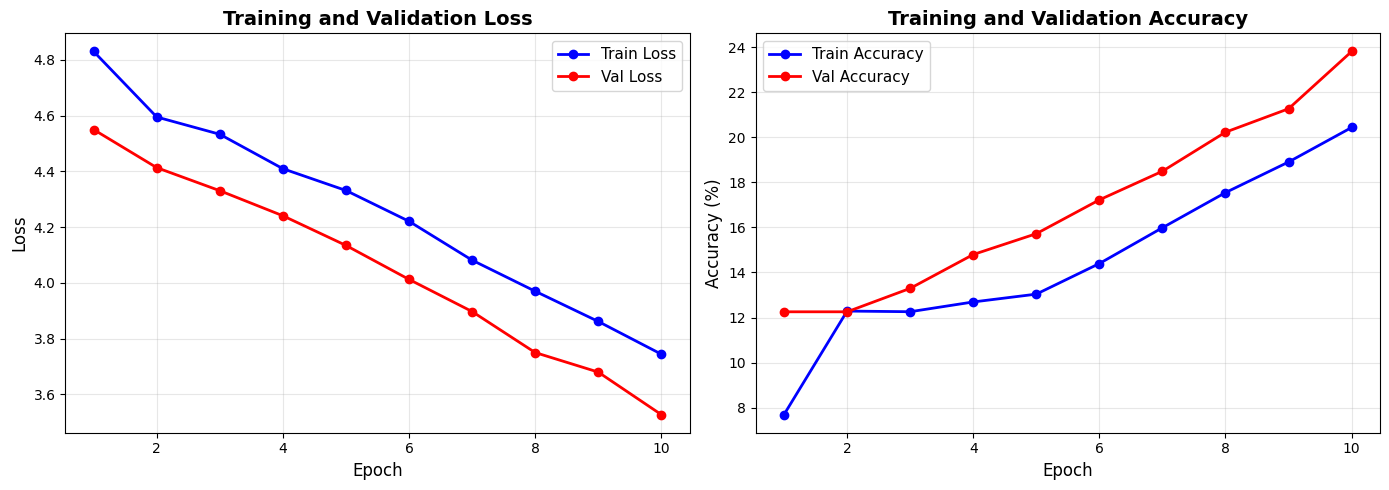

In [15]:
# Configurazione
config = {
    'input_channels': 3,
    'num_filters': [32, 64, 128],
    'kernel_sizes': [3, 3, 3],
    'fc_hidden_size': 512,
    'embedding_size': 128,
    'num_classes': 5749,
    'dropout_rate': 0.5,
    'use_batchnorm': True,
    'use_global_avg_pool': False
}

# Carica dataset
train_loader, test_loader, num_classes = load_lfw_dataset(
    data_dir='./content/data',
    img_size=128,
    batch_size=64,
    augment=True
)

# Aggiorna numero classi
config['num_classes'] = num_classes

# Crea modello
model = create_cnn_model(config)

# Training
model, history = train_model(
    model=model,
    config=config,
    train_loader=train_loader,
    test_loader=test_loader,
    num_epochs=10,
    learning_rate=1e-3,
    checkpoint_dir='./checkpoints/cnn_baseline',
    device=None  # auto-detect
)

# Plot risultati
plot_training_history(history, save_path='./checkpoints/cnn_baseline/training_history.png')

# Different Configuration
Dato il funzionamento del codice --> cicliamo su diverse configurazioni per vedere quale é la migliore  come aggiungedo best practices migliora (speriamo) i risultati

## Importante: Early stopping
Dato che le configurazion i sono molte, non ha senso allenare una Rete se non miglira, quindi implemento Early Stopping

In [11]:
class EarlyStopping:
    """
    Early stopping per fermare il training quando validation non migliora
    """
    def __init__(self, patience=3, min_delta=0.001, verbose=True):
        """
        Args:
            patience: quante epoche aspettare senza miglioramento
            min_delta: minimo miglioramento considerato significativo
            verbose: stampa messaggi
        """
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_metric):
        """
        Args:
            val_metric: metrica di validazione (es. accuracy)

        Returns:
            True se deve fermarsi, False altrimenti
        """
        score = val_metric

        if self.best_score is None:
            self.best_score = score
            return False

        if score < self.best_score + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f"  EarlyStopping counter: {self.counter}/{self.patience}")

            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f"  Early stopping triggered!")
                return True
        else:
            self.best_score = score
            self.counter = 0

        return False

## Configruazioni utilizzate
Configurazioni diverse dalla più semplice alla più ottimizzata

In [12]:
def get_cnn_configs():
    """
    Configurazioni CNN dalla più semplice alla più ottimizzata

    Returns:
        dict con tutte le configurazioni
    """
    configs = {
        # 8. ResNet18 Transfer Learning - backbone congelato
        'resnet18_frozen': {
            'model_config': {
                'use_pretrained_resnet': True,
                'resnet_version': 'resnet18',
                'freeze_resnet_backbone': True,  # Backbone congelato
                'num_filters': [256, 256],  # 2 residual blocks custom
                'kernel_sizes': [3, 3],
                'fc_hidden_size': 512,
                'embedding_size': 128,
                'num_classes': 5749,
                'dropout_rate': 0.3,
                'use_batchnorm': True,
                'use_global_avg_pool': True  # Sempre True per ResNet
            },
            'training_config': {
                'learning_rate': 1e-3,  # LR normale (backbone congelato)
                'batch_size': 64,
                'num_epochs': 35,
                'optimizer': 'adam',
                'weight_decay': 1e-4,
                'label_smoothing': 0.1,
                'early_stopping_patience': 8
            }
        },

        # 9. ResNet18 Transfer Learning - fine-tuning
        'resnet18_finetuned': {
            'model_config': {
                'use_pretrained_resnet': True,
                'resnet_version': 'resnet18',
                'freeze_resnet_backbone': False,  # Backbone trainabile
                'num_filters': [256, 256],
                'kernel_sizes': [3, 3],
                'fc_hidden_size': 512,
                'embedding_size': 128,
                'num_classes': 5749,
                'dropout_rate': 0.3,
                'use_batchnorm': True,
                'use_global_avg_pool': True
            },
            'training_config': {
                'learning_rate': 1e-4,  # LR basso (tutto trainabile)
                'batch_size': 32,  # Batch più piccolo
                'num_epochs': 35,
                'optimizer': 'adam',
                'weight_decay': 1e-4,
                'label_smoothing': 0.1,
                'early_stopping_patience': 8
            }
        },

        # 10. ResNet34 Transfer Learning - modello più grande
        'resnet34_frozen': {
            'model_config': {
                'use_pretrained_resnet': True,
                'resnet_version': 'resnet34',
                'freeze_resnet_backbone': True,
                'num_filters': [384, 256],  # Più filtri per ResNet34
                'kernel_sizes': [3, 3],
                'fc_hidden_size': 768,
                'embedding_size': 256,
                'num_classes': 5749,
                'dropout_rate': 0.3,
                'use_batchnorm': True,
                'use_global_avg_pool': True
            },
            'training_config': {
                'learning_rate': 1e-3,
                'batch_size': 48,
                'num_epochs': 35,
                'optimizer': 'adam',
                'weight_decay': 1e-4,
                'label_smoothing': 0.1,
                'early_stopping_patience': 8
            }
        },

        # 11. ResNet50 Transfer Learning - massima capacità
        'resnet50_frozen': {
            'model_config': {
                'use_pretrained_resnet': True,
                'resnet_version': 'resnet50',
                'freeze_resnet_backbone': True,
                'num_filters': [512, 256],  # Adatto a ResNet50 (output 2048)
                'kernel_sizes': [3, 3],
                'fc_hidden_size': 1024,
                'embedding_size': 256,
                'num_classes': 5749,
                'dropout_rate': 0.4,
                'use_batchnorm': True,
                'use_global_avg_pool': True
            },
            'training_config': {
                'learning_rate': 1e-3,
                'batch_size': 32,  # Batch piccolo (ResNet50 pesante)
                'num_epochs': 35,
                'optimizer': 'adam',
                'weight_decay': 1e-4,
                'label_smoothing': 0.1,
                'early_stopping_patience': 8
            }
        }
    }

    return configs

## Training singola istanza di config
Pressoché identico a la cella che runnava il training precedente MA adesso legge dalle config + early stopping

In [13]:
def train_model_with_config(model_class, config_name, config, train_loader, test_loader,
                            num_classes, checkpoint_dir='./checkpoints', device=None):
    """
    Train un modello con una specifica configurazione

    Args:
        model_class: classe del modello (es. create_dnn_model)
        config_name: nome della configurazione
        config: dict con model_config e training_config
        train_loader: DataLoader training
        test_loader: DataLoader validation
        num_classes: numero di classi
        checkpoint_dir: directory base per checkpoints
        device: device (cuda/cpu)

    Returns:
        model, history, best_val_acc
    """
    # Setup device
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Estrai configurazioni
    model_config = config['model_config'].copy()
    model_config['num_classes'] = num_classes
    training_config = config['training_config']

    # Crea modello
    model = model_class(model_config)
    model = model.to(device)

    # Loss function (con label smoothing opzionale)
    criterion = nn.CrossEntropyLoss(label_smoothing=training_config['label_smoothing'])

    # Optimizer
    if training_config['optimizer'] == 'adam':
        optimizer = optim.Adam(
            model.parameters(),
            lr=training_config['learning_rate'],
            weight_decay=training_config['weight_decay']
        )
    elif training_config['optimizer'] == 'rmsprop':
        optimizer = optim.RMSprop(
            model.parameters(),
            lr=training_config['learning_rate'],
            weight_decay=training_config['weight_decay']
        )
    else:  # sgd
        optimizer = optim.SGD(
            model.parameters(),
            lr=training_config['learning_rate'],
            momentum=0.9,
            weight_decay=training_config['weight_decay']
        )

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=2
    )

    # Early stopping
    early_stopping = EarlyStopping(
        patience=training_config['early_stopping_patience'],
        verbose=True
    )

    # Directory per questa configurazione
    config_checkpoint_dir = os.path.join(checkpoint_dir, config_name)
    os.makedirs(config_checkpoint_dir, exist_ok=True)

    # Salva configurazione
    config_path = os.path.join(config_checkpoint_dir, 'config.json')
    with open(config_path, 'w') as f:
        json.dump(config, f, indent=4)

    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    best_val_acc = 0.0

    print("\n" + "="*70)
    print(f"TRAINING: {config_name}")
    print("="*70)
    print(f"Model config: {model_config}")
    print(f"Training config: {training_config}")
    print("="*70 + "\n")

    num_epochs = training_config['num_epochs']

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 70)

        # Training
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, device
        )

        # Validation
        val_loss, val_acc = validate(
            model, test_loader, criterion, device
        )

        # Update scheduler
        scheduler.step(val_acc)

        # Salva storia
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Print summary
        print(f"\nEpoch {epoch+1} Summary:")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        # Salva best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_path = os.path.join(config_checkpoint_dir, 'best_model.pth')
            save_checkpoint(model, optimizer, config, epoch+1, val_acc, best_model_path)
            print(f"  *** Nuovo best model! Accuracy: {val_acc:.2f}% ***")

        # Early stopping check
        if early_stopping(val_acc):
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

    # Salva ultimo checkpoint
    last_checkpoint_path = os.path.join(config_checkpoint_dir, 'last_checkpoint.pth')
    save_checkpoint(model, optimizer, config, epoch+1, val_acc, last_checkpoint_path)

    # Salva history
    history_path = os.path.join(config_checkpoint_dir, 'history.json')
    with open(history_path, 'w') as f:
        json.dump(history, f, indent=4)

    print("\n" + "="*70)
    print(f"TRAINING COMPLETATO: {config_name}")
    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
    print("="*70 + "\n")

    return model, history, best_val_acc

## Training di tutte le diverse Config

In [14]:
def train_multiple_configs(model_class, train_loader, test_loader, num_classes,
                          checkpoint_dir='./checkpoints', device=None):
    """
    Train modelli con tutte le configurazioni predefinite

    Args:
        model_class: classe del modello
        train_loader: DataLoader training
        test_loader: DataLoader validation
        num_classes: numero di classi
        checkpoint_dir: directory per checkpoints
        device: device (cuda/cpu)

    Returns:
        results: dict con risultati di ogni config
    """
    configs = get_cnn_configs()
    results = {}

    for config_name, config in configs.items():
        print(f"\n{'='*70}")
        print(f"Starting training: {config_name}")
        print(f"{'='*70}\n")

        try:
            # Train con configurazione base
            model, history, best_val_acc = train_model_with_config(
                model_class=model_class,
                config_name=config_name,
                config=config,
                train_loader=train_loader,
                test_loader=test_loader,
                num_classes=num_classes,
                checkpoint_dir=checkpoint_dir,
                device=device
            )
            
            # NUOVO: Fine-tuning per configurazioni ResNet frozen
            if config_name.endswith('_frozen') and 'resnet' in config_name:
                print(f"\n{'='*70}")
                print(f"Starting FINE-TUNING phase: {config_name}")
                print(f"{'='*70}\n")
                
                # Scongela e fine-tune con LR molto basso
                model, history_ft = unfreeze_and_finetune(
                    model, train_loader, test_loader,
                    num_epochs=5,  # Poche epoche per fine-tuning
                    learning_rate=1e-5,  # LR molto basso
                    checkpoint_dir=os.path.join(checkpoint_dir, config_name),
                    device=device
                )
                
                # Aggiorna best accuracy se migliorata
                best_val_acc_ft = max(history_ft['val_acc'])
                if best_val_acc_ft > best_val_acc:
                    best_val_acc = best_val_acc_ft
                    print(f"Fine-tuning migliorato: {best_val_acc:.2f}%")
            
            results[config_name] = {
                'best_val_acc': best_val_acc,
                'history': history,
                'config': config
            }
            
        except Exception as e:
            print(f"\nERROR training {config_name}: {e}")
            results[config_name] = {'error': str(e)}


    # Salva summary
    summary_path = os.path.join(checkpoint_dir, 'training_summary.json')
    summary = {
        name: {'best_val_acc': res.get('best_val_acc', 0)}
        for name, res in results.items()
    }
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=4)

    # Stampa summary
    print("\n" + "="*70)
    print("TRAINING SUMMARY - All Configurations")
    print("="*70)
    for name, res in results.items():
        if 'best_val_acc' in res:
            print(f"{name:20s}: {res['best_val_acc']:.2f}%")
        else:
            print(f"{name:20s}: ERROR")
    print("="*70 + "\n")

    return results

# Training Multiple Config

In [15]:
train_loader, test_loader, num_classes = load_lfw_dataset(
    data_dir='./content/data',
    img_size=128,
    batch_size=64,
    augment=True
)

# Train tutte le configurazioni
results = train_multiple_configs(
    model_class=create_cnn_model,
    train_loader=train_loader,
    test_loader=test_loader,
    num_classes=num_classes,
    checkpoint_dir='./checkpoints/Transfer_learning_CNN',
    device=None
)

Download LFW con sklearn...
Dataset scaricato:
  Totale samples: 4324
  Dimensione immagini: (125, 94, 3)
  Num classes: 158

DataLoaders creati:
  Train samples: 3459
  Test samples: 865
  Batch size: 64

Starting training: resnet18_frozen



/root/Git/Progetto_DeepLearning_e_architetture_di_Reti_Neurali/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/Git/Progetto_DeepLearning_e_architetture_di_Reti_Neurali/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



TRAINING: resnet18_frozen
Model config: {'use_pretrained_resnet': True, 'resnet_version': 'resnet18', 'freeze_resnet_backbone': True, 'num_filters': [256, 256], 'kernel_sizes': [3, 3], 'fc_hidden_size': 512, 'embedding_size': 128, 'num_classes': 158, 'dropout_rate': 0.3, 'use_batchnorm': True, 'use_global_avg_pool': True}
Training config: {'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 35, 'optimizer': 'adam', 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'early_stopping_patience': 8}


Epoch 1/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.10it/s, loss=4.9570, acc=18.61%]



Epoch 1 Summary:
  Train Loss: 4.6715 | Train Acc: 13.18%
  Val Loss: 4.3876 | Val Acc: 18.61%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 18.61% ***

Epoch 2/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 26.32it/s, loss=4.8375, acc=20.23%]



Epoch 2 Summary:
  Train Loss: 4.3082 | Train Acc: 18.76%
  Val Loss: 4.1802 | Val Acc: 20.23%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 20.23% ***

Epoch 3/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.47it/s, loss=4.5988, acc=23.82%]



Epoch 3 Summary:
  Train Loss: 4.1381 | Train Acc: 20.87%
  Val Loss: 3.9883 | Val Acc: 23.82%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 23.82% ***

Epoch 4/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 28.32it/s, loss=4.4405, acc=24.86%]



Epoch 4 Summary:
  Train Loss: 3.9515 | Train Acc: 22.84%
  Val Loss: 3.8481 | Val Acc: 24.86%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 24.86% ***

Epoch 5/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 26.02it/s, loss=4.4238, acc=26.36%]



Epoch 5 Summary:
  Train Loss: 3.8794 | Train Acc: 24.95%
  Val Loss: 3.8018 | Val Acc: 26.36%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 26.36% ***

Epoch 6/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.86it/s, loss=4.3987, acc=26.82%]



Epoch 6 Summary:
  Train Loss: 3.8043 | Train Acc: 23.68%
  Val Loss: 3.7592 | Val Acc: 26.82%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 26.82% ***

Epoch 7/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.81it/s, loss=4.3797, acc=26.36%]



Epoch 7 Summary:
  Train Loss: 3.7109 | Train Acc: 26.08%
  Val Loss: 3.7251 | Val Acc: 26.36%
  EarlyStopping counter: 1/8

Epoch 8/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 28.06it/s, loss=4.1322, acc=28.55%]



Epoch 8 Summary:
  Train Loss: 3.6716 | Train Acc: 27.20%
  Val Loss: 3.6404 | Val Acc: 28.55%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 28.55% ***

Epoch 9/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 25.80it/s, loss=4.3411, acc=27.86%]



Epoch 9 Summary:
  Train Loss: 3.5569 | Train Acc: 28.88%
  Val Loss: 3.6974 | Val Acc: 27.86%
  EarlyStopping counter: 1/8

Epoch 10/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.46it/s, loss=4.2580, acc=28.79%]



Epoch 10 Summary:
  Train Loss: 3.5626 | Train Acc: 28.42%
  Val Loss: 3.6522 | Val Acc: 28.79%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 28.79% ***

Epoch 11/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.58it/s, loss=4.0895, acc=30.64%]



Epoch 11 Summary:
  Train Loss: 3.4470 | Train Acc: 30.36%
  Val Loss: 3.5422 | Val Acc: 30.64%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 30.64% ***

Epoch 12/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 28.33it/s, loss=4.3058, acc=30.52%]



Epoch 12 Summary:
  Train Loss: 3.4508 | Train Acc: 31.37%
  Val Loss: 3.5585 | Val Acc: 30.52%
  EarlyStopping counter: 1/8

Epoch 13/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.50it/s, loss=3.8885, acc=32.83%]



Epoch 13 Summary:
  Train Loss: 3.4142 | Train Acc: 32.52%
  Val Loss: 3.4610 | Val Acc: 32.83%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 32.83% ***

Epoch 14/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.48it/s, loss=4.0980, acc=32.02%]



Epoch 14 Summary:
  Train Loss: 3.3732 | Train Acc: 33.25%
  Val Loss: 3.4622 | Val Acc: 32.02%
  EarlyStopping counter: 1/8

Epoch 15/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.76it/s, loss=4.0206, acc=31.91%]



Epoch 15 Summary:
  Train Loss: 3.3319 | Train Acc: 34.29%
  Val Loss: 3.4559 | Val Acc: 31.91%
  EarlyStopping counter: 2/8

Epoch 16/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.24it/s, loss=4.1598, acc=32.37%]



Epoch 16 Summary:
  Train Loss: 3.3055 | Train Acc: 33.56%
  Val Loss: 3.4843 | Val Acc: 32.37%
  EarlyStopping counter: 3/8

Epoch 17/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.40it/s, loss=3.9564, acc=34.22%]



Epoch 17 Summary:
  Train Loss: 3.2225 | Train Acc: 35.44%
  Val Loss: 3.3697 | Val Acc: 34.22%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 34.22% ***

Epoch 18/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.75it/s, loss=3.8591, acc=36.30%]



Epoch 18 Summary:
  Train Loss: 3.1826 | Train Acc: 36.02%
  Val Loss: 3.2994 | Val Acc: 36.30%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 36.30% ***

Epoch 19/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.36it/s, loss=3.8138, acc=36.65%]



Epoch 19 Summary:
  Train Loss: 3.1510 | Train Acc: 36.80%
  Val Loss: 3.2615 | Val Acc: 36.65%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 36.65% ***

Epoch 20/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.88it/s, loss=3.7552, acc=37.23%]



Epoch 20 Summary:
  Train Loss: 3.1162 | Train Acc: 37.47%
  Val Loss: 3.2577 | Val Acc: 37.23%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 37.23% ***

Epoch 21/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 26.28it/s, loss=3.8530, acc=37.57%]



Epoch 21 Summary:
  Train Loss: 3.0982 | Train Acc: 38.74%
  Val Loss: 3.2849 | Val Acc: 37.57%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 37.57% ***

Epoch 22/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 28.25it/s, loss=3.7015, acc=39.08%]



Epoch 22 Summary:
  Train Loss: 3.0746 | Train Acc: 38.97%
  Val Loss: 3.2218 | Val Acc: 39.08%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 39.08% ***

Epoch 23/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 28.16it/s, loss=3.6637, acc=37.80%]



Epoch 23 Summary:
  Train Loss: 3.0707 | Train Acc: 38.16%
  Val Loss: 3.2427 | Val Acc: 37.80%
  EarlyStopping counter: 1/8

Epoch 24/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.14it/s, loss=3.7593, acc=38.96%]



Epoch 24 Summary:
  Train Loss: 3.0308 | Train Acc: 39.20%
  Val Loss: 3.2434 | Val Acc: 38.96%
  EarlyStopping counter: 2/8

Epoch 25/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 28.12it/s, loss=3.7435, acc=37.80%]



Epoch 25 Summary:
  Train Loss: 3.0630 | Train Acc: 40.07%
  Val Loss: 3.2426 | Val Acc: 37.80%
  EarlyStopping counter: 3/8

Epoch 26/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.00it/s, loss=3.7025, acc=38.27%]



Epoch 26 Summary:
  Train Loss: 2.9652 | Train Acc: 41.11%
  Val Loss: 3.1997 | Val Acc: 38.27%
  EarlyStopping counter: 4/8

Epoch 27/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.87it/s, loss=3.6350, acc=38.73%]



Epoch 27 Summary:
  Train Loss: 2.9504 | Train Acc: 42.44%
  Val Loss: 3.1955 | Val Acc: 38.73%
  EarlyStopping counter: 5/8

Epoch 28/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.72it/s, loss=3.5442, acc=39.42%]



Epoch 28 Summary:
  Train Loss: 2.9487 | Train Acc: 42.50%
  Val Loss: 3.1784 | Val Acc: 39.42%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 39.42% ***

Epoch 29/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.85it/s, loss=3.6724, acc=38.61%]



Epoch 29 Summary:
  Train Loss: 2.9014 | Train Acc: 42.70%
  Val Loss: 3.1713 | Val Acc: 38.61%
  EarlyStopping counter: 1/8

Epoch 30/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.64it/s, loss=3.6546, acc=38.96%]



Epoch 30 Summary:
  Train Loss: 2.9104 | Train Acc: 43.34%
  Val Loss: 3.1675 | Val Acc: 38.96%
  EarlyStopping counter: 2/8

Epoch 31/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 26.85it/s, loss=3.6405, acc=38.84%]



Epoch 31 Summary:
  Train Loss: 2.8937 | Train Acc: 44.35%
  Val Loss: 3.1850 | Val Acc: 38.84%
  EarlyStopping counter: 3/8

Epoch 32/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.50it/s, loss=3.5547, acc=40.12%]



Epoch 32 Summary:
  Train Loss: 2.8498 | Train Acc: 44.09%
  Val Loss: 3.1534 | Val Acc: 40.12%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 40.12% ***

Epoch 33/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.16it/s, loss=3.5522, acc=39.88%]



Epoch 33 Summary:
  Train Loss: 2.8559 | Train Acc: 45.27%
  Val Loss: 3.1633 | Val Acc: 39.88%
  EarlyStopping counter: 1/8

Epoch 34/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.29it/s, loss=3.6096, acc=39.19%]



Epoch 34 Summary:
  Train Loss: 2.8828 | Train Acc: 42.73%
  Val Loss: 3.1586 | Val Acc: 39.19%
  EarlyStopping counter: 2/8

Epoch 35/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.69it/s, loss=3.5581, acc=39.42%]



Epoch 35 Summary:
  Train Loss: 2.8147 | Train Acc: 44.17%
  Val Loss: 3.1401 | Val Acc: 39.42%
  EarlyStopping counter: 3/8
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_frozen/last_checkpoint.pth

TRAINING COMPLETATO: resnet18_frozen
Best Validation Accuracy: 40.12%


Starting FINE-TUNING phase: resnet18_frozen

Backbone scongelato per fine-tuning
Using device: cuda
Transfer learning: backbone LR=0.000000, nuovi layer LR=0.000010

INIZIO TRAINING


Epoch 1/5
------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.81it/s, loss=3.1383, acc=39.65%]



Epoch 1 Summary:
  Train Loss: 2.3760 | Train Acc: 44.61%
  Val Loss: 2.7189 | Val Acc: 39.65%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 39.65% ***
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_frozen/last_checkpoint.pth

Epoch 2/5
------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.68it/s, loss=3.1569, acc=40.35%]



Epoch 2 Summary:
  Train Loss: 2.3772 | Train Acc: 45.07%
  Val Loss: 2.6992 | Val Acc: 40.35%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 40.35% ***
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_frozen/last_checkpoint.pth

Epoch 3/5
------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.03it/s, loss=3.1246, acc=39.77%]



Epoch 3 Summary:
  Train Loss: 2.3272 | Train Acc: 45.88%
  Val Loss: 2.7145 | Val Acc: 39.77%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_frozen/last_checkpoint.pth

Epoch 4/5
------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.75it/s, loss=3.1738, acc=40.46%]



Epoch 4 Summary:
  Train Loss: 2.3318 | Train Acc: 44.46%
  Val Loss: 2.7070 | Val Acc: 40.46%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 40.46% ***
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_frozen/last_checkpoint.pth

Epoch 5/5
------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 26.86it/s, loss=3.1853, acc=40.12%]



Epoch 5 Summary:
  Train Loss: 2.3246 | Train Acc: 46.34%
  Val Loss: 2.6941 | Val Acc: 40.12%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_frozen/last_checkpoint.pth

TRAINING COMPLETATO
Best Validation Accuracy: 40.46%

Fine-tuning migliorato: 40.46%

Starting training: resnet18_finetuned


TRAINING: resnet18_finetuned
Model config: {'use_pretrained_resnet': True, 'resnet_version': 'resnet18', 'freeze_resnet_backbone': False, 'num_filters': [256, 256], 'kernel_sizes': [3, 3], 'fc_hidden_size': 512, 'embedding_size': 128, 'num_classes': 158, 'dropout_rate': 0.3, 'use_batchnorm': True, 'use_global_avg_pool': True}
Training config: {'learning_rate': 0.0001, 'batch_size': 32, 'num_epochs': 35, 'optimizer': 'adam', 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'early_stopping_patience': 8}


Epoch 1/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.56it/s, loss=4.9915, acc=14.68%]



Epoch 1 Summary:
  Train Loss: 5.0761 | Train Acc: 1.76%
  Val Loss: 4.8697 | Val Acc: 14.68%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_finetuned/best_model.pth
  *** Nuovo best model! Accuracy: 14.68% ***

Epoch 2/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.47it/s, loss=4.7802, acc=20.92%]



Epoch 2 Summary:
  Train Loss: 4.6866 | Train Acc: 14.48%
  Val Loss: 4.4322 | Val Acc: 20.92%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_finetuned/best_model.pth
  *** Nuovo best model! Accuracy: 20.92% ***

Epoch 3/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 28.09it/s, loss=4.7052, acc=25.43%]



Epoch 3 Summary:
  Train Loss: 4.3732 | Train Acc: 21.02%
  Val Loss: 4.1961 | Val Acc: 25.43%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_finetuned/best_model.pth
  *** Nuovo best model! Accuracy: 25.43% ***

Epoch 4/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.49it/s, loss=4.6168, acc=30.87%]



Epoch 4 Summary:
  Train Loss: 4.1284 | Train Acc: 25.64%
  Val Loss: 3.9972 | Val Acc: 30.87%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_finetuned/best_model.pth
  *** Nuovo best model! Accuracy: 30.87% ***

Epoch 5/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 26.66it/s, loss=4.5550, acc=32.83%]



Epoch 5 Summary:
  Train Loss: 3.9671 | Train Acc: 28.74%
  Val Loss: 3.8436 | Val Acc: 32.83%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_finetuned/best_model.pth
  *** Nuovo best model! Accuracy: 32.83% ***

Epoch 6/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.66it/s, loss=4.4354, acc=34.91%]



Epoch 6 Summary:
  Train Loss: 3.8299 | Train Acc: 30.70%
  Val Loss: 3.7054 | Val Acc: 34.91%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_finetuned/best_model.pth
  *** Nuovo best model! Accuracy: 34.91% ***

Epoch 7/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.21it/s, loss=4.3657, acc=36.30%]



Epoch 7 Summary:
  Train Loss: 3.6849 | Train Acc: 33.07%
  Val Loss: 3.6046 | Val Acc: 36.30%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_finetuned/best_model.pth
  *** Nuovo best model! Accuracy: 36.30% ***

Epoch 8/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.96it/s, loss=4.2139, acc=37.11%]



Epoch 8 Summary:
  Train Loss: 3.6428 | Train Acc: 33.91%
  Val Loss: 3.5504 | Val Acc: 37.11%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_finetuned/best_model.pth
  *** Nuovo best model! Accuracy: 37.11% ***

Epoch 9/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.33it/s, loss=3.9867, acc=38.27%]



Epoch 9 Summary:
  Train Loss: 3.5565 | Train Acc: 35.94%
  Val Loss: 3.4242 | Val Acc: 38.27%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_finetuned/best_model.pth
  *** Nuovo best model! Accuracy: 38.27% ***

Epoch 10/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.41it/s, loss=3.7853, acc=39.31%]



Epoch 10 Summary:
  Train Loss: 3.4873 | Train Acc: 37.58%
  Val Loss: 3.3246 | Val Acc: 39.31%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_finetuned/best_model.pth
  *** Nuovo best model! Accuracy: 39.31% ***

Epoch 11/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 26.74it/s, loss=3.6880, acc=40.92%]



Epoch 11 Summary:
  Train Loss: 3.3976 | Train Acc: 39.49%
  Val Loss: 3.2959 | Val Acc: 40.92%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_finetuned/best_model.pth
  *** Nuovo best model! Accuracy: 40.92% ***

Epoch 12/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.25it/s, loss=3.6337, acc=41.16%]



Epoch 12 Summary:
  Train Loss: 3.3618 | Train Acc: 40.50%
  Val Loss: 3.2511 | Val Acc: 41.16%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_finetuned/best_model.pth
  *** Nuovo best model! Accuracy: 41.16% ***

Epoch 13/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.51it/s, loss=3.5535, acc=42.66%]



Epoch 13 Summary:
  Train Loss: 3.2778 | Train Acc: 40.91%
  Val Loss: 3.1546 | Val Acc: 42.66%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_finetuned/best_model.pth
  *** Nuovo best model! Accuracy: 42.66% ***

Epoch 14/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 28.04it/s, loss=3.5283, acc=45.55%]



Epoch 14 Summary:
  Train Loss: 3.2146 | Train Acc: 42.93%
  Val Loss: 3.1326 | Val Acc: 45.55%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_finetuned/best_model.pth
  *** Nuovo best model! Accuracy: 45.55% ***

Epoch 15/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.97it/s, loss=3.4805, acc=46.59%]



Epoch 15 Summary:
  Train Loss: 3.1233 | Train Acc: 45.13%
  Val Loss: 3.0454 | Val Acc: 46.59%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_finetuned/best_model.pth
  *** Nuovo best model! Accuracy: 46.59% ***

Epoch 16/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.15it/s, loss=3.3721, acc=47.28%]



Epoch 16 Summary:
  Train Loss: 3.0873 | Train Acc: 45.71%
  Val Loss: 2.9783 | Val Acc: 47.28%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_finetuned/best_model.pth
  *** Nuovo best model! Accuracy: 47.28% ***

Epoch 17/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 26.27it/s, loss=3.3635, acc=48.21%]



Epoch 17 Summary:
  Train Loss: 3.0276 | Train Acc: 46.98%
  Val Loss: 2.9656 | Val Acc: 48.21%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_finetuned/best_model.pth
  *** Nuovo best model! Accuracy: 48.21% ***

Epoch 18/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.85it/s, loss=3.2582, acc=48.90%]



Epoch 18 Summary:
  Train Loss: 2.9923 | Train Acc: 46.95%
  Val Loss: 2.8839 | Val Acc: 48.90%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_finetuned/best_model.pth
  *** Nuovo best model! Accuracy: 48.90% ***

Epoch 19/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.51it/s, loss=3.2169, acc=49.60%]



Epoch 19 Summary:
  Train Loss: 2.9168 | Train Acc: 49.03%
  Val Loss: 2.8542 | Val Acc: 49.60%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_finetuned/best_model.pth
  *** Nuovo best model! Accuracy: 49.60% ***

Epoch 20/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.86it/s, loss=3.1565, acc=50.40%]



Epoch 20 Summary:
  Train Loss: 2.8723 | Train Acc: 49.44%
  Val Loss: 2.8042 | Val Acc: 50.40%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_finetuned/best_model.pth
  *** Nuovo best model! Accuracy: 50.40% ***

Epoch 21/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.33it/s, loss=3.0473, acc=52.49%]



Epoch 21 Summary:
  Train Loss: 2.8000 | Train Acc: 51.11%
  Val Loss: 2.7081 | Val Acc: 52.49%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_finetuned/best_model.pth
  *** Nuovo best model! Accuracy: 52.49% ***

Epoch 22/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.25it/s, loss=3.0104, acc=53.64%]



Epoch 22 Summary:
  Train Loss: 2.7051 | Train Acc: 52.79%
  Val Loss: 2.6502 | Val Acc: 53.64%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_finetuned/best_model.pth
  *** Nuovo best model! Accuracy: 53.64% ***

Epoch 23/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.49it/s, loss=2.9890, acc=55.14%]



Epoch 23 Summary:
  Train Loss: 2.7086 | Train Acc: 53.51%
  Val Loss: 2.6057 | Val Acc: 55.14%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_finetuned/best_model.pth
  *** Nuovo best model! Accuracy: 55.14% ***

Epoch 24/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.55it/s, loss=3.0278, acc=55.95%]



Epoch 24 Summary:
  Train Loss: 2.6306 | Train Acc: 54.99%
  Val Loss: 2.5943 | Val Acc: 55.95%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_finetuned/best_model.pth
  *** Nuovo best model! Accuracy: 55.95% ***

Epoch 25/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.58it/s, loss=2.9055, acc=56.76%]



Epoch 25 Summary:
  Train Loss: 2.5660 | Train Acc: 55.80%
  Val Loss: 2.5301 | Val Acc: 56.76%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_finetuned/best_model.pth
  *** Nuovo best model! Accuracy: 56.76% ***

Epoch 26/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.97it/s, loss=2.8605, acc=56.99%]



Epoch 26 Summary:
  Train Loss: 2.5359 | Train Acc: 56.66%
  Val Loss: 2.4876 | Val Acc: 56.99%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_finetuned/best_model.pth
  *** Nuovo best model! Accuracy: 56.99% ***

Epoch 27/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.73it/s, loss=2.7889, acc=58.84%]



Epoch 27 Summary:
  Train Loss: 2.4602 | Train Acc: 58.34%
  Val Loss: 2.4322 | Val Acc: 58.84%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_finetuned/best_model.pth
  *** Nuovo best model! Accuracy: 58.84% ***

Epoch 28/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 26.96it/s, loss=2.7922, acc=59.65%]



Epoch 28 Summary:
  Train Loss: 2.4339 | Train Acc: 59.96%
  Val Loss: 2.3767 | Val Acc: 59.65%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_finetuned/best_model.pth
  *** Nuovo best model! Accuracy: 59.65% ***

Epoch 29/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.76it/s, loss=2.8473, acc=59.65%]



Epoch 29 Summary:
  Train Loss: 2.4609 | Train Acc: 58.75%
  Val Loss: 2.3821 | Val Acc: 59.65%
  EarlyStopping counter: 1/8

Epoch 30/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 28.23it/s, loss=2.6041, acc=60.58%]



Epoch 30 Summary:
  Train Loss: 2.3716 | Train Acc: 60.97%
  Val Loss: 2.3215 | Val Acc: 60.58%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_finetuned/best_model.pth
  *** Nuovo best model! Accuracy: 60.58% ***

Epoch 31/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.88it/s, loss=2.5439, acc=61.50%]



Epoch 31 Summary:
  Train Loss: 2.3113 | Train Acc: 62.79%
  Val Loss: 2.2862 | Val Acc: 61.50%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_finetuned/best_model.pth
  *** Nuovo best model! Accuracy: 61.50% ***

Epoch 32/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 26.95it/s, loss=2.5892, acc=61.62%]



Epoch 32 Summary:
  Train Loss: 2.2811 | Train Acc: 63.69%
  Val Loss: 2.2635 | Val Acc: 61.62%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_finetuned/best_model.pth
  *** Nuovo best model! Accuracy: 61.62% ***

Epoch 33/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.10it/s, loss=2.6235, acc=62.89%]



Epoch 33 Summary:
  Train Loss: 2.3375 | Train Acc: 61.98%
  Val Loss: 2.2407 | Val Acc: 62.89%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_finetuned/best_model.pth
  *** Nuovo best model! Accuracy: 62.89% ***

Epoch 34/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.47it/s, loss=2.5255, acc=64.97%]



Epoch 34 Summary:
  Train Loss: 2.2109 | Train Acc: 64.99%
  Val Loss: 2.1828 | Val Acc: 64.97%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_finetuned/best_model.pth
  *** Nuovo best model! Accuracy: 64.97% ***

Epoch 35/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.60it/s, loss=2.5195, acc=65.20%]



Epoch 35 Summary:
  Train Loss: 2.2112 | Train Acc: 66.46%
  Val Loss: 2.1334 | Val Acc: 65.20%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_finetuned/best_model.pth
  *** Nuovo best model! Accuracy: 65.20% ***
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet18_finetuned/last_checkpoint.pth

TRAINING COMPLETATO: resnet18_finetuned
Best Validation Accuracy: 65.20%


Starting training: resnet34_frozen



/root/Git/Progetto_DeepLearning_e_architetture_di_Reti_Neurali/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



TRAINING: resnet34_frozen
Model config: {'use_pretrained_resnet': True, 'resnet_version': 'resnet34', 'freeze_resnet_backbone': True, 'num_filters': [384, 256], 'kernel_sizes': [3, 3], 'fc_hidden_size': 768, 'embedding_size': 256, 'num_classes': 158, 'dropout_rate': 0.3, 'use_batchnorm': True, 'use_global_avg_pool': True}
Training config: {'learning_rate': 0.001, 'batch_size': 48, 'num_epochs': 35, 'optimizer': 'adam', 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'early_stopping_patience': 8}


Epoch 1/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 26.74it/s, loss=4.6782, acc=19.08%]



Epoch 1 Summary:
  Train Loss: 4.5648 | Train Acc: 14.92%
  Val Loss: 4.2598 | Val Acc: 19.08%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 19.08% ***

Epoch 2/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.41it/s, loss=4.4562, acc=21.62%]



Epoch 2 Summary:
  Train Loss: 4.2037 | Train Acc: 20.47%
  Val Loss: 4.0103 | Val Acc: 21.62%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 21.62% ***

Epoch 3/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.08it/s, loss=4.2953, acc=22.43%]



Epoch 3 Summary:
  Train Loss: 3.9702 | Train Acc: 22.06%
  Val Loss: 4.0243 | Val Acc: 22.43%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 22.43% ***

Epoch 4/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.65it/s, loss=4.1959, acc=25.66%]



Epoch 4 Summary:
  Train Loss: 3.8660 | Train Acc: 23.24%
  Val Loss: 3.7603 | Val Acc: 25.66%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 25.66% ***

Epoch 5/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 25.79it/s, loss=4.1349, acc=27.17%]



Epoch 5 Summary:
  Train Loss: 3.7572 | Train Acc: 25.73%
  Val Loss: 3.6782 | Val Acc: 27.17%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 27.17% ***

Epoch 6/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 26.57it/s, loss=3.9953, acc=29.02%]



Epoch 6 Summary:
  Train Loss: 3.6410 | Train Acc: 28.10%
  Val Loss: 3.5955 | Val Acc: 29.02%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 29.02% ***

Epoch 7/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 26.26it/s, loss=3.9160, acc=29.25%]



Epoch 7 Summary:
  Train Loss: 3.5912 | Train Acc: 28.59%
  Val Loss: 3.5541 | Val Acc: 29.25%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 29.25% ***

Epoch 8/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 26.87it/s, loss=3.8782, acc=28.67%]



Epoch 8 Summary:
  Train Loss: 3.5323 | Train Acc: 29.43%
  Val Loss: 3.5773 | Val Acc: 28.67%
  EarlyStopping counter: 1/8

Epoch 9/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.60it/s, loss=3.8283, acc=30.29%]



Epoch 9 Summary:
  Train Loss: 3.4090 | Train Acc: 30.85%
  Val Loss: 3.4551 | Val Acc: 30.29%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 30.29% ***

Epoch 10/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 26.61it/s, loss=3.8518, acc=29.60%]



Epoch 10 Summary:
  Train Loss: 3.3698 | Train Acc: 32.29%
  Val Loss: 3.4607 | Val Acc: 29.60%
  EarlyStopping counter: 1/8

Epoch 11/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 26.78it/s, loss=3.7877, acc=32.83%]



Epoch 11 Summary:
  Train Loss: 3.3617 | Train Acc: 30.99%
  Val Loss: 3.3388 | Val Acc: 32.83%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 32.83% ***

Epoch 12/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 24.18it/s, loss=3.7563, acc=35.14%]



Epoch 12 Summary:
  Train Loss: 3.2948 | Train Acc: 34.06%
  Val Loss: 3.2769 | Val Acc: 35.14%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 35.14% ***

Epoch 13/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 24.29it/s, loss=3.6645, acc=34.45%]



Epoch 13 Summary:
  Train Loss: 3.2399 | Train Acc: 34.92%
  Val Loss: 3.3019 | Val Acc: 34.45%
  EarlyStopping counter: 1/8

Epoch 14/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 24.11it/s, loss=3.9172, acc=32.60%]



Epoch 14 Summary:
  Train Loss: 3.2037 | Train Acc: 35.01%
  Val Loss: 3.4008 | Val Acc: 32.60%
  EarlyStopping counter: 2/8

Epoch 15/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 23.98it/s, loss=3.5946, acc=36.65%]



Epoch 15 Summary:
  Train Loss: 3.1297 | Train Acc: 36.80%
  Val Loss: 3.2609 | Val Acc: 36.65%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 36.65% ***

Epoch 16/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 23.11it/s, loss=3.6214, acc=35.26%]



Epoch 16 Summary:
  Train Loss: 3.1765 | Train Acc: 36.25%
  Val Loss: 3.2608 | Val Acc: 35.26%
  EarlyStopping counter: 1/8

Epoch 17/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 23.63it/s, loss=3.4120, acc=37.46%]



Epoch 17 Summary:
  Train Loss: 3.1139 | Train Acc: 36.80%
  Val Loss: 3.2297 | Val Acc: 37.46%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 37.46% ***

Epoch 18/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.05it/s, loss=3.4479, acc=37.23%]



Epoch 18 Summary:
  Train Loss: 3.0315 | Train Acc: 39.00%
  Val Loss: 3.1806 | Val Acc: 37.23%
  EarlyStopping counter: 1/8

Epoch 19/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.16it/s, loss=3.2877, acc=36.42%]



Epoch 19 Summary:
  Train Loss: 3.0644 | Train Acc: 38.51%
  Val Loss: 3.1921 | Val Acc: 36.42%
  EarlyStopping counter: 2/8

Epoch 20/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.06it/s, loss=3.4775, acc=36.99%]



Epoch 20 Summary:
  Train Loss: 3.0481 | Train Acc: 39.38%
  Val Loss: 3.1652 | Val Acc: 36.99%
  EarlyStopping counter: 3/8

Epoch 21/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 26.73it/s, loss=3.2102, acc=39.65%]



Epoch 21 Summary:
  Train Loss: 2.8866 | Train Acc: 42.50%
  Val Loss: 3.0683 | Val Acc: 39.65%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 39.65% ***

Epoch 22/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 26.66it/s, loss=3.0540, acc=40.46%]



Epoch 22 Summary:
  Train Loss: 2.8910 | Train Acc: 42.56%
  Val Loss: 3.0320 | Val Acc: 40.46%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 40.46% ***

Epoch 23/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.39it/s, loss=3.1341, acc=40.69%]



Epoch 23 Summary:
  Train Loss: 2.8103 | Train Acc: 43.77%
  Val Loss: 3.0196 | Val Acc: 40.69%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 40.69% ***

Epoch 24/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.12it/s, loss=3.0915, acc=41.04%]



Epoch 24 Summary:
  Train Loss: 2.8148 | Train Acc: 43.86%
  Val Loss: 3.0378 | Val Acc: 41.04%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 41.04% ***

Epoch 25/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 25.94it/s, loss=3.0979, acc=40.69%]



Epoch 25 Summary:
  Train Loss: 2.7643 | Train Acc: 44.43%
  Val Loss: 2.9883 | Val Acc: 40.69%
  EarlyStopping counter: 1/8

Epoch 26/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 26.99it/s, loss=3.1732, acc=43.01%]



Epoch 26 Summary:
  Train Loss: 2.7542 | Train Acc: 45.33%
  Val Loss: 2.9757 | Val Acc: 43.01%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 43.01% ***

Epoch 27/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 26.87it/s, loss=3.0957, acc=42.31%]



Epoch 27 Summary:
  Train Loss: 2.7230 | Train Acc: 46.52%
  Val Loss: 2.9800 | Val Acc: 42.31%
  EarlyStopping counter: 1/8

Epoch 28/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.55it/s, loss=3.1226, acc=41.16%]



Epoch 28 Summary:
  Train Loss: 2.7106 | Train Acc: 46.14%
  Val Loss: 2.9850 | Val Acc: 41.16%
  EarlyStopping counter: 2/8

Epoch 29/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 26.88it/s, loss=3.3239, acc=41.39%]



Epoch 29 Summary:
  Train Loss: 2.7422 | Train Acc: 45.50%
  Val Loss: 3.0132 | Val Acc: 41.39%
  EarlyStopping counter: 3/8

Epoch 30/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 26.77it/s, loss=3.1276, acc=43.35%]



Epoch 30 Summary:
  Train Loss: 2.6745 | Train Acc: 47.90%
  Val Loss: 2.9422 | Val Acc: 43.35%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 43.35% ***

Epoch 31/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.39it/s, loss=3.1598, acc=42.89%]



Epoch 31 Summary:
  Train Loss: 2.6908 | Train Acc: 47.56%
  Val Loss: 2.9446 | Val Acc: 42.89%
  EarlyStopping counter: 1/8

Epoch 32/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 26.98it/s, loss=3.1412, acc=43.58%]



Epoch 32 Summary:
  Train Loss: 2.6053 | Train Acc: 49.73%
  Val Loss: 2.9019 | Val Acc: 43.58%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 43.58% ***

Epoch 33/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 26.76it/s, loss=3.0998, acc=43.58%]



Epoch 33 Summary:
  Train Loss: 2.6073 | Train Acc: 49.55%
  Val Loss: 2.9110 | Val Acc: 43.58%
  EarlyStopping counter: 1/8

Epoch 34/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 26.77it/s, loss=3.1428, acc=43.70%]



Epoch 34 Summary:
  Train Loss: 2.5891 | Train Acc: 49.49%
  Val Loss: 2.8937 | Val Acc: 43.70%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 43.70% ***

Epoch 35/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 26.66it/s, loss=3.1737, acc=44.51%]



Epoch 35 Summary:
  Train Loss: 2.5776 | Train Acc: 50.19%
  Val Loss: 2.9034 | Val Acc: 44.51%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 44.51% ***
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet34_frozen/last_checkpoint.pth

TRAINING COMPLETATO: resnet34_frozen
Best Validation Accuracy: 44.51%


Starting FINE-TUNING phase: resnet34_frozen

Backbone scongelato per fine-tuning
Using device: cuda
Transfer learning: backbone LR=0.000000, nuovi layer LR=0.000010

INIZIO TRAINING


Epoch 1/5
------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 27.06it/s, loss=2.5902, acc=44.51%]



Epoch 1 Summary:
  Train Loss: 2.0125 | Train Acc: 51.40%
  Val Loss: 2.3823 | Val Acc: 44.51%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 44.51% ***
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet34_frozen/last_checkpoint.pth

Epoch 2/5
------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 24.36it/s, loss=2.6381, acc=44.16%]



Epoch 2 Summary:
  Train Loss: 2.0123 | Train Acc: 51.43%
  Val Loss: 2.3674 | Val Acc: 44.16%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet34_frozen/last_checkpoint.pth

Epoch 3/5
------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 23.80it/s, loss=2.6504, acc=43.70%]



Epoch 3 Summary:
  Train Loss: 2.0134 | Train Acc: 51.66%
  Val Loss: 2.3499 | Val Acc: 43.70%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet34_frozen/last_checkpoint.pth

Epoch 4/5
------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 23.12it/s, loss=2.5857, acc=43.82%]



Epoch 4 Summary:
  Train Loss: 2.0259 | Train Acc: 51.69%
  Val Loss: 2.3576 | Val Acc: 43.82%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet34_frozen/last_checkpoint.pth

Epoch 5/5
------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 23.83it/s, loss=2.5538, acc=43.47%]



Epoch 5 Summary:
  Train Loss: 2.0051 | Train Acc: 51.98%
  Val Loss: 2.3400 | Val Acc: 43.47%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet34_frozen/last_checkpoint.pth

TRAINING COMPLETATO
Best Validation Accuracy: 44.51%


Starting training: resnet50_frozen



/root/Git/Progetto_DeepLearning_e_architetture_di_Reti_Neurali/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



TRAINING: resnet50_frozen
Model config: {'use_pretrained_resnet': True, 'resnet_version': 'resnet50', 'freeze_resnet_backbone': True, 'num_filters': [512, 256], 'kernel_sizes': [3, 3], 'fc_hidden_size': 1024, 'embedding_size': 256, 'num_classes': 158, 'dropout_rate': 0.4, 'use_batchnorm': True, 'use_global_avg_pool': True}
Training config: {'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 35, 'optimizer': 'adam', 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'early_stopping_patience': 8}


Epoch 1/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 24.28it/s, loss=4.8870, acc=17.23%]



Epoch 1 Summary:
  Train Loss: 4.6446 | Train Acc: 14.19%
  Val Loss: 4.4128 | Val Acc: 17.23%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet50_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 17.23% ***

Epoch 2/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 24.73it/s, loss=4.6588, acc=20.12%]



Epoch 2 Summary:
  Train Loss: 4.2598 | Train Acc: 19.11%
  Val Loss: 4.1685 | Val Acc: 20.12%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet50_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 20.12% ***

Epoch 3/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 24.68it/s, loss=4.2243, acc=22.08%]



Epoch 3 Summary:
  Train Loss: 4.0616 | Train Acc: 21.39%
  Val Loss: 3.9358 | Val Acc: 22.08%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet50_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 22.08% ***

Epoch 4/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 24.31it/s, loss=4.1108, acc=24.39%]



Epoch 4 Summary:
  Train Loss: 3.9281 | Train Acc: 23.01%
  Val Loss: 3.8586 | Val Acc: 24.39%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet50_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 24.39% ***

Epoch 5/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 25.02it/s, loss=4.0157, acc=27.17%]



Epoch 5 Summary:
  Train Loss: 3.7604 | Train Acc: 25.87%
  Val Loss: 3.7093 | Val Acc: 27.17%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet50_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 27.17% ***

Epoch 6/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 24.35it/s, loss=3.9423, acc=26.01%]



Epoch 6 Summary:
  Train Loss: 3.6985 | Train Acc: 25.73%
  Val Loss: 3.7300 | Val Acc: 26.01%
  EarlyStopping counter: 1/8

Epoch 7/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 24.77it/s, loss=3.8025, acc=28.79%]



Epoch 7 Summary:
  Train Loss: 3.6137 | Train Acc: 28.04%
  Val Loss: 3.5805 | Val Acc: 28.79%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet50_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 28.79% ***

Epoch 8/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 25.22it/s, loss=3.7164, acc=28.67%]



Epoch 8 Summary:
  Train Loss: 3.5431 | Train Acc: 29.43%
  Val Loss: 3.5964 | Val Acc: 28.67%
  EarlyStopping counter: 1/8

Epoch 9/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 25.47it/s, loss=3.7731, acc=28.32%]



Epoch 9 Summary:
  Train Loss: 3.4622 | Train Acc: 30.12%
  Val Loss: 3.5761 | Val Acc: 28.32%
  EarlyStopping counter: 2/8

Epoch 10/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 25.39it/s, loss=3.9129, acc=30.40%]



Epoch 10 Summary:
  Train Loss: 3.4685 | Train Acc: 30.12%
  Val Loss: 3.5438 | Val Acc: 30.40%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet50_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 30.40% ***

Epoch 11/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 24.97it/s, loss=3.8336, acc=31.45%]



Epoch 11 Summary:
  Train Loss: 3.3733 | Train Acc: 31.34%
  Val Loss: 3.4694 | Val Acc: 31.45%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet50_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 31.45% ***

Epoch 12/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 24.86it/s, loss=3.8055, acc=32.14%]



Epoch 12 Summary:
  Train Loss: 3.3452 | Train Acc: 32.49%
  Val Loss: 3.4358 | Val Acc: 32.14%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet50_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 32.14% ***

Epoch 13/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 21.32it/s, loss=3.7487, acc=30.40%]



Epoch 13 Summary:
  Train Loss: 3.3593 | Train Acc: 32.67%
  Val Loss: 3.4348 | Val Acc: 30.40%
  EarlyStopping counter: 1/8

Epoch 14/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 25.24it/s, loss=3.9633, acc=31.91%]



Epoch 14 Summary:
  Train Loss: 3.2278 | Train Acc: 34.35%
  Val Loss: 3.4081 | Val Acc: 31.91%
  EarlyStopping counter: 2/8

Epoch 15/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 24.80it/s, loss=3.8503, acc=33.06%]



Epoch 15 Summary:
  Train Loss: 3.2200 | Train Acc: 34.92%
  Val Loss: 3.3560 | Val Acc: 33.06%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet50_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 33.06% ***

Epoch 16/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 24.84it/s, loss=3.4723, acc=36.07%]



Epoch 16 Summary:
  Train Loss: 3.1429 | Train Acc: 35.62%
  Val Loss: 3.2161 | Val Acc: 36.07%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet50_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 36.07% ***

Epoch 17/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 25.37it/s, loss=3.5978, acc=33.18%]



Epoch 17 Summary:
  Train Loss: 3.1375 | Train Acc: 37.27%
  Val Loss: 3.2680 | Val Acc: 33.18%
  EarlyStopping counter: 1/8

Epoch 18/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 24.77it/s, loss=3.6693, acc=35.26%]



Epoch 18 Summary:
  Train Loss: 3.1860 | Train Acc: 36.43%
  Val Loss: 3.2344 | Val Acc: 35.26%
  EarlyStopping counter: 2/8

Epoch 19/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 24.90it/s, loss=3.7190, acc=34.91%]



Epoch 19 Summary:
  Train Loss: 3.0777 | Train Acc: 36.98%
  Val Loss: 3.2283 | Val Acc: 34.91%
  EarlyStopping counter: 3/8

Epoch 20/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 24.20it/s, loss=3.4709, acc=37.69%]



Epoch 20 Summary:
  Train Loss: 2.9987 | Train Acc: 39.55%
  Val Loss: 3.1040 | Val Acc: 37.69%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet50_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 37.69% ***

Epoch 21/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 25.17it/s, loss=3.4116, acc=40.92%]



Epoch 21 Summary:
  Train Loss: 2.9564 | Train Acc: 41.14%
  Val Loss: 3.0774 | Val Acc: 40.92%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet50_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 40.92% ***

Epoch 22/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 25.16it/s, loss=3.3552, acc=40.35%]



Epoch 22 Summary:
  Train Loss: 2.8442 | Train Acc: 42.96%
  Val Loss: 3.0303 | Val Acc: 40.35%
  EarlyStopping counter: 1/8

Epoch 23/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 24.05it/s, loss=3.3022, acc=38.15%]



Epoch 23 Summary:
  Train Loss: 2.8651 | Train Acc: 43.25%
  Val Loss: 3.0653 | Val Acc: 38.15%
  EarlyStopping counter: 2/8

Epoch 24/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 24.56it/s, loss=3.4317, acc=37.34%]



Epoch 24 Summary:
  Train Loss: 2.8557 | Train Acc: 43.13%
  Val Loss: 3.1388 | Val Acc: 37.34%
  EarlyStopping counter: 3/8

Epoch 25/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 25.14it/s, loss=3.2534, acc=40.81%]



Epoch 25 Summary:
  Train Loss: 2.7725 | Train Acc: 45.56%
  Val Loss: 2.9550 | Val Acc: 40.81%
  EarlyStopping counter: 4/8

Epoch 26/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 25.13it/s, loss=3.3042, acc=39.31%]



Epoch 26 Summary:
  Train Loss: 2.7070 | Train Acc: 46.63%
  Val Loss: 2.9829 | Val Acc: 39.31%
  EarlyStopping counter: 5/8

Epoch 27/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 24.66it/s, loss=3.2239, acc=40.35%]



Epoch 27 Summary:
  Train Loss: 2.6979 | Train Acc: 47.30%
  Val Loss: 2.9509 | Val Acc: 40.35%
  EarlyStopping counter: 6/8

Epoch 28/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 25.06it/s, loss=3.1297, acc=41.85%]



Epoch 28 Summary:
  Train Loss: 2.6858 | Train Acc: 48.86%
  Val Loss: 2.9082 | Val Acc: 41.85%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet50_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 41.85% ***

Epoch 29/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 25.25it/s, loss=3.1781, acc=41.73%]



Epoch 29 Summary:
  Train Loss: 2.6439 | Train Acc: 48.71%
  Val Loss: 2.9194 | Val Acc: 41.73%
  EarlyStopping counter: 1/8

Epoch 30/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 23.99it/s, loss=3.1827, acc=40.92%]



Epoch 30 Summary:
  Train Loss: 2.6035 | Train Acc: 48.66%
  Val Loss: 2.8895 | Val Acc: 40.92%
  EarlyStopping counter: 2/8

Epoch 31/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 25.22it/s, loss=3.1036, acc=41.97%]



Epoch 31 Summary:
  Train Loss: 2.5730 | Train Acc: 50.25%
  Val Loss: 2.8844 | Val Acc: 41.97%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet50_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 41.97% ***

Epoch 32/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 25.35it/s, loss=3.1974, acc=42.77%]



Epoch 32 Summary:
  Train Loss: 2.5464 | Train Acc: 49.81%
  Val Loss: 2.8822 | Val Acc: 42.77%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet50_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 42.77% ***

Epoch 33/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 24.74it/s, loss=3.1778, acc=43.24%]



Epoch 33 Summary:
  Train Loss: 2.5866 | Train Acc: 50.48%
  Val Loss: 2.8827 | Val Acc: 43.24%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet50_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 43.24% ***

Epoch 34/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 25.19it/s, loss=3.2230, acc=42.54%]



Epoch 34 Summary:
  Train Loss: 2.5442 | Train Acc: 49.96%
  Val Loss: 2.8814 | Val Acc: 42.54%
  EarlyStopping counter: 1/8

Epoch 35/35
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 24.47it/s, loss=3.1809, acc=42.66%]



Epoch 35 Summary:
  Train Loss: 2.5314 | Train Acc: 50.74%
  Val Loss: 2.8701 | Val Acc: 42.66%
  EarlyStopping counter: 2/8
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet50_frozen/last_checkpoint.pth

TRAINING COMPLETATO: resnet50_frozen
Best Validation Accuracy: 43.24%


Starting FINE-TUNING phase: resnet50_frozen

Backbone scongelato per fine-tuning
Using device: cuda
Transfer learning: backbone LR=0.000000, nuovi layer LR=0.000010

INIZIO TRAINING


Epoch 1/5
------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 24.63it/s, loss=2.6942, acc=43.93%]



Epoch 1 Summary:
  Train Loss: 1.9838 | Train Acc: 53.37%
  Val Loss: 2.3751 | Val Acc: 43.93%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet50_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 43.93% ***
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet50_frozen/last_checkpoint.pth

Epoch 2/5
------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 24.87it/s, loss=2.6252, acc=44.39%]



Epoch 2 Summary:
  Train Loss: 2.0353 | Train Acc: 50.85%
  Val Loss: 2.3466 | Val Acc: 44.39%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet50_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 44.39% ***
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet50_frozen/last_checkpoint.pth

Epoch 3/5
------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 25.12it/s, loss=2.7014, acc=44.28%]



Epoch 3 Summary:
  Train Loss: 1.9549 | Train Acc: 52.44%
  Val Loss: 2.3614 | Val Acc: 44.28%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet50_frozen/last_checkpoint.pth

Epoch 4/5
------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 24.49it/s, loss=2.6726, acc=44.62%]



Epoch 4 Summary:
  Train Loss: 2.0152 | Train Acc: 52.18%
  Val Loss: 2.3493 | Val Acc: 44.62%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet50_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 44.62% ***
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet50_frozen/last_checkpoint.pth

Epoch 5/5
------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:00<00:00, 24.69it/s, loss=2.6348, acc=43.93%]



Epoch 5 Summary:
  Train Loss: 1.9502 | Train Acc: 53.11%
  Val Loss: 2.3460 | Val Acc: 43.93%
Checkpoint salvato: ./checkpoints/Transfer_learning_CNN/resnet50_frozen/last_checkpoint.pth

TRAINING COMPLETATO
Best Validation Accuracy: 44.62%

Fine-tuning migliorato: 44.62%

TRAINING SUMMARY - All Configurations
resnet18_frozen     : 40.46%
resnet18_finetuned  : 65.20%
resnet34_frozen     : 44.51%
resnet50_frozen     : 44.62%



# Riassunto Modelli

In [16]:
def plot_overfitting_analysis(checkpoint_dir='./checkpoints/cnn_experiments', save_path=None):
    """
    Analizza e plotta l'overfitting: confronta train vs val accuracy con gap evidenziato

    Args:
        checkpoint_dir: directory con le sottocartelle delle config
        save_path: (opzionale) path dove salvare il grafico
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    config_names = sorted([d for d in os.listdir(checkpoint_dir)
                          if os.path.isdir(os.path.join(checkpoint_dir, d))])

    overfitting_data = []

    for idx, config_name in enumerate(config_names[:6]):  # Max 6 plots
        history_path = os.path.join(checkpoint_dir, config_name, 'history.json')

        if not os.path.exists(history_path):
            continue

        with open(history_path, 'r') as f:
            history = json.load(f)

        epochs = range(1, len(history['train_acc']) + 1)
        train_acc = history['train_acc']
        val_acc = history['val_acc']

        # Calcola gap (overfitting indicator)
        final_train = train_acc[-1]
        final_val = val_acc[-1]
        gap = final_train - final_val

        overfitting_data.append({
            'config': config_name,
            'train_acc': final_train,
            'val_acc': final_val,
            'gap': gap
        })

        # Plot train vs val
        ax = axes[idx]
        ax.plot(epochs, train_acc, 'b-o', label='Train Acc', linewidth=2, markersize=4)
        ax.plot(epochs, val_acc, 'r-s', label='Val Acc', linewidth=2, markersize=4)

        # Evidenzia gap finale
        ax.axhline(y=final_train, color='b', linestyle='--', alpha=0.3)
        ax.axhline(y=final_val, color='r', linestyle='--', alpha=0.3)
        ax.fill_between(epochs, final_train, final_val, alpha=0.2, color='orange')

        # Aggiungi testo con gap
        gap_text = f'Gap: {gap:.1f}%'
        if gap > 15:
            gap_text += ' (OVERFITTING!)'
            color = 'red'
        elif gap > 5:
            gap_text += ' (Moderate)'
            color = 'orange'
        else:
            gap_text += ' (Good)'
            color = 'green'

        ax.text(0.5, 0.95, gap_text, transform=ax.transAxes,
               fontsize=11, fontweight='bold', color=color,
               ha='center', va='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        ax.set_xlabel('Epoch', fontsize=10)
        ax.set_ylabel('Accuracy (%)', fontsize=10)
        ax.set_title(f'{config_name}\nTrain: {final_train:.1f}% | Val: {final_val:.1f}%',
                    fontsize=11, fontweight='bold')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)

    # Nascondi assi non usati
    for idx in range(len(config_names), 6):
        axes[idx].axis('off')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Grafico overfitting salvato: {save_path}")

    plt.show()

    # Stampa tabella overfitting
    print("\n" + "="*80)
    print("OVERFITTING ANALYSIS")
    print("="*80)
    print(f"{'Config':<25} | {'Train Acc':>10} | {'Val Acc':>10} | {'Gap':>10} | {'Status':<15}")
    print("-"*80)

    for data in sorted(overfitting_data, key=lambda x: x['gap'], reverse=True):
        if data['gap'] > 15:
            status = 'OVERFITTING!'
        elif data['gap'] > 5:
            status = 'Moderate'
        else:
            status = 'Good'

        print(f"{data['config']:<25} | {data['train_acc']:>9.2f}% | {data['val_acc']:>9.2f}% | "
              f"{data['gap']:>9.2f}% | {status:<15}")

    print("="*80)
    print("Note: Gap = Train Acc - Val Acc")
    print("  Gap > 15% = Severe overfitting")
    print("  Gap 5-15% = Moderate overfitting")
    print("  Gap < 5%  = Good generalization")
    print("="*80 + "\n")

In [17]:
def print_models_summary(model_class, checkpoint_dir='./checkpoints/cnn_experiments'):
    """
    Stampa tabella comparativa con stats di tutti i modelli trainati

    Args:
        model_class: classe del modello (es. create_dnn_model)
        checkpoint_dir: directory con le sottocartelle delle config
    """
    print("\n" + "="*90)
    print("SUMMARY - All Trained Models")
    print("="*90)
    print(f"{'Config':<20} | {'Parameters':>15} | {'Best Val Acc':>13} | {'Epochs':>7}")
    print("-"*90)

    results = []

    for config_name in sorted(os.listdir(checkpoint_dir)):
        config_path = os.path.join(checkpoint_dir, config_name)

        if not os.path.isdir(config_path):
            continue

        # Carica best model
        best_model_path = os.path.join(config_path, 'best_model.pth')
        if not os.path.exists(best_model_path):
            continue

        try:
            # Carica modello
            checkpoint = torch.load(best_model_path, map_location='cpu')
            config = checkpoint['config']['model_config']
            model = model_class(config)

            # Conta parametri
            total_params = sum(p.numel() for p in model.parameters())

            # Carica history per best accuracy e num epochs
            history_path = os.path.join(config_path, 'history.json')
            with open(history_path, 'r') as f:
                history = json.load(f)

            best_val_acc = max(history['val_acc'])
            num_epochs = len(history['train_loss'])

            # Stampa riga
            print(f"{config_name:<20} | {total_params:>15,} | {best_val_acc:>12.2f}% | {num_epochs:>7}")

            results.append({
                'config': config_name,
                'params': total_params,
                'best_acc': best_val_acc,
                'epochs': num_epochs
            })

        except Exception as e:
            print(f"{config_name:<20} | {'ERROR':>15} | {'-':>13} | {'-':>7}")

    print("="*90)

    # Trova best model
    if results:
        best = max(results, key=lambda x: x['best_acc'])
        print(f"\nBest Model: {best['config']} with {best['best_acc']:.2f}% accuracy")
        print(f"   Parameters: {best['params']:,}")
        print(f"   Epochs trained: {best['epochs']}")

In [18]:
print_models_summary(
    model_class=create_cnn_model,
    checkpoint_dir='./checkpoints/Transfer_learning_CNN'
)


SUMMARY - All Trained Models
Config               |      Parameters |  Best Val Acc |  Epochs
------------------------------------------------------------------------------------------
resnet18_finetuned   |      15,200,693 |        65.20% |      35
resnet18_frozen      |           ERROR |             - |       -
resnet34_frozen      |           ERROR |             - |       -
resnet50_frozen      |           ERROR |             - |       -

Best Model: resnet18_finetuned with 65.20% accuracy
   Parameters: 15,200,693
   Epochs trained: 35


Grafico overfitting salvato: ./checkpoints/Transfer_learning_CNN/overfitting_analysis.png


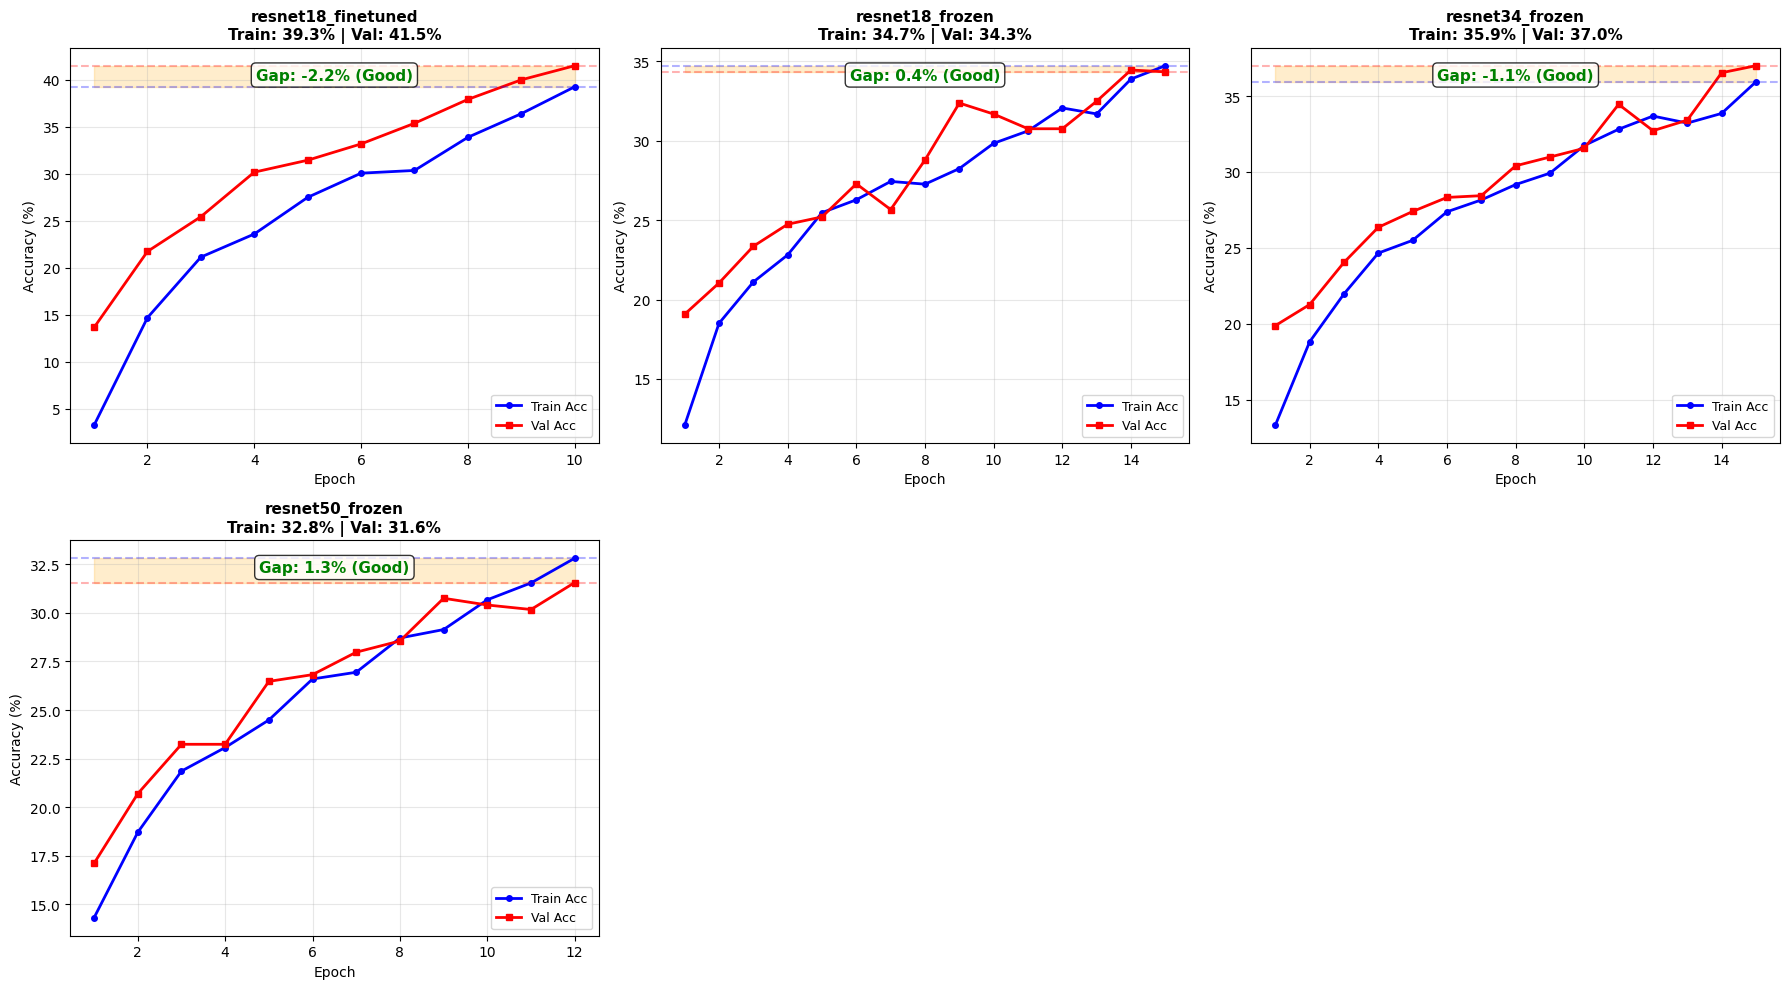


OVERFITTING ANALYSIS
Config                    |  Train Acc |    Val Acc |        Gap | Status         
--------------------------------------------------------------------------------
resnet50_frozen           |     32.81% |     31.56% |      1.25% | Good           
resnet18_frozen           |     34.72% |     34.34% |      0.39% | Good           
resnet34_frozen           |     35.94% |     36.99% |     -1.06% | Good           
resnet18_finetuned        |     39.26% |     41.50% |     -2.24% | Good           
Note: Gap = Train Acc - Val Acc
  Gap > 15% = Severe overfitting
  Gap 5-15% = Moderate overfitting
  Gap < 5%  = Good generalization



In [27]:
plot_overfitting_analysis(
    checkpoint_dir='./checkpoints/Transfer_learning_CNN',
    save_path='./checkpoints/Transfer_learning_CNN/overfitting_analysis.png'
)

# Plot diverse History

In [19]:
def plot_all_histories(checkpoint_dir='./checkpoints/cnn_experiments', save_path=None):
    """
    Plotta tutte le history delle diverse configurazioni per confronto

    Args:
        checkpoint_dir: directory con le sottocartelle delle config
        save_path: (opzionale) path dove salvare il grafico
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Trova tutte le configurazioni
    config_names = [d for d in os.listdir(checkpoint_dir)
                   if os.path.isdir(os.path.join(checkpoint_dir, d))]

    # Colori per ogni config
    colors = plt.cm.tab10(np.linspace(0, 1, len(config_names)))

    for idx, config_name in enumerate(sorted(config_names)):
        history_path = os.path.join(checkpoint_dir, config_name, 'history.json')

        if not os.path.exists(history_path):
            print(f"Warning: history.json non trovato per {config_name}")
            continue

        # Carica history
        with open(history_path, 'r') as f:
            history = json.load(f)

        epochs = range(1, len(history['train_loss']) + 1)
        color = colors[idx]

        # Plot Train Loss
        axes[0, 0].plot(epochs, history['train_loss'],
                       color=color, marker='o', linewidth=2,
                       label=config_name, alpha=0.8)

        # Plot Val Loss
        axes[0, 1].plot(epochs, history['val_loss'],
                       color=color, marker='s', linewidth=2,
                       label=config_name, alpha=0.8)

        # Plot Train Accuracy
        axes[1, 0].plot(epochs, history['train_acc'],
                       color=color, marker='o', linewidth=2,
                       label=config_name, alpha=0.8)

        # Plot Val Accuracy
        axes[1, 1].plot(epochs, history['val_acc'],
                       color=color, marker='s', linewidth=2,
                       label=config_name, alpha=0.8)

    # Configurazione assi
    axes[0, 0].set_xlabel('Epoch', fontsize=12)
    axes[0, 0].set_ylabel('Loss', fontsize=12)
    axes[0, 0].set_title('Training Loss - All Configs', fontsize=14, fontweight='bold')
    axes[0, 0].legend(fontsize=9, loc='best')
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].set_xlabel('Epoch', fontsize=12)
    axes[0, 1].set_ylabel('Loss', fontsize=12)
    axes[0, 1].set_title('Validation Loss - All Configs', fontsize=14, fontweight='bold')
    axes[0, 1].legend(fontsize=9, loc='best')
    axes[0, 1].grid(True, alpha=0.3)

    axes[1, 0].set_xlabel('Epoch', fontsize=12)
    axes[1, 0].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1, 0].set_title('Training Accuracy - All Configs', fontsize=14, fontweight='bold')
    axes[1, 0].legend(fontsize=9, loc='best')
    axes[1, 0].grid(True, alpha=0.3)

    axes[1, 1].set_xlabel('Epoch', fontsize=12)
    axes[1, 1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1, 1].set_title('Validation Accuracy - All Configs', fontsize=14, fontweight='bold')
    axes[1, 1].legend(fontsize=9, loc='best')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Grafico confronto salvato: {save_path}")

    plt.show()


def plot_final_comparison(checkpoint_dir='./checkpoints/cnn_experiments', save_path=None):
    """
    Crea un bar plot con le best validation accuracy di tutte le config

    Args:
        checkpoint_dir: directory con le sottocartelle delle config
        save_path: (opzionale) path dove salvare il grafico
    """
    config_names = []
    best_accs = []

    # Raccogli tutte le best accuracy
    for config_name in sorted(os.listdir(checkpoint_dir)):
        config_path = os.path.join(checkpoint_dir, config_name)
        if not os.path.isdir(config_path):
            continue

        history_path = os.path.join(config_path, 'history.json')
        if not os.path.exists(history_path):
            continue

        with open(history_path, 'r') as f:
            history = json.load(f)

        best_acc = max(history['val_acc'])
        config_names.append(config_name)
        best_accs.append(best_acc)

    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))

    bars = ax.bar(range(len(config_names)), best_accs,
                   color=plt.cm.viridis(np.linspace(0, 1, len(config_names))),
                   edgecolor='black', linewidth=1.5)

    # Aggiungi valori sopra le barre
    for i, (name, acc) in enumerate(zip(config_names, best_accs)):
        ax.text(i, acc + 0.5, f'{acc:.2f}%',
               ha='center', va='bottom', fontsize=11, fontweight='bold')

    ax.set_xlabel('Configuration', fontsize=13, fontweight='bold')
    ax.set_ylabel('Best Validation Accuracy (%)', fontsize=13, fontweight='bold')
    ax.set_title('Comparison of Best Validation Accuracy - All Configurations',
                fontsize=15, fontweight='bold')
    ax.set_xticks(range(len(config_names)))
    ax.set_xticklabels(config_names, rotation=45, ha='right')
    ax.grid(True, axis='y', alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Grafico confronto finale salvato: {save_path}")

    plt.show()

Grafico confronto salvato: ./checkpoints/Transfer_learning_CNN/all_histories_comparison.png


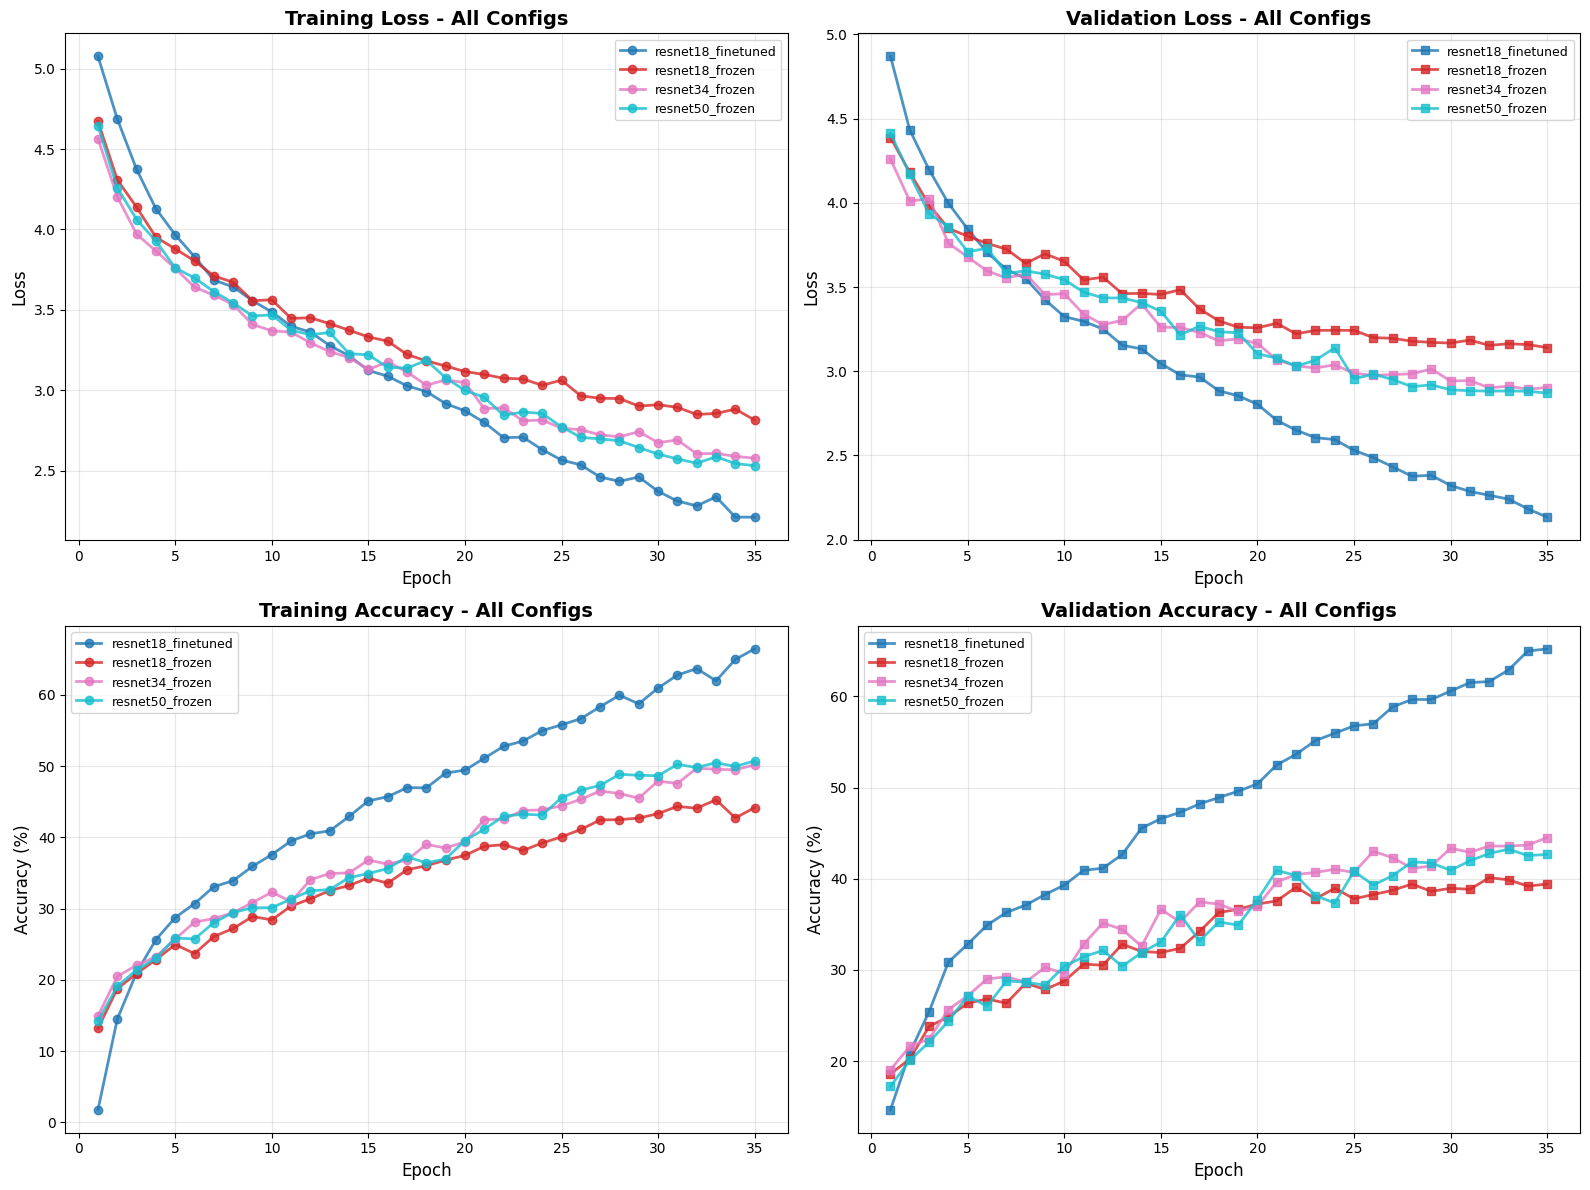

Grafico confronto finale salvato: ./checkpoints/Transfer_learning_CNN/final_comparison.png


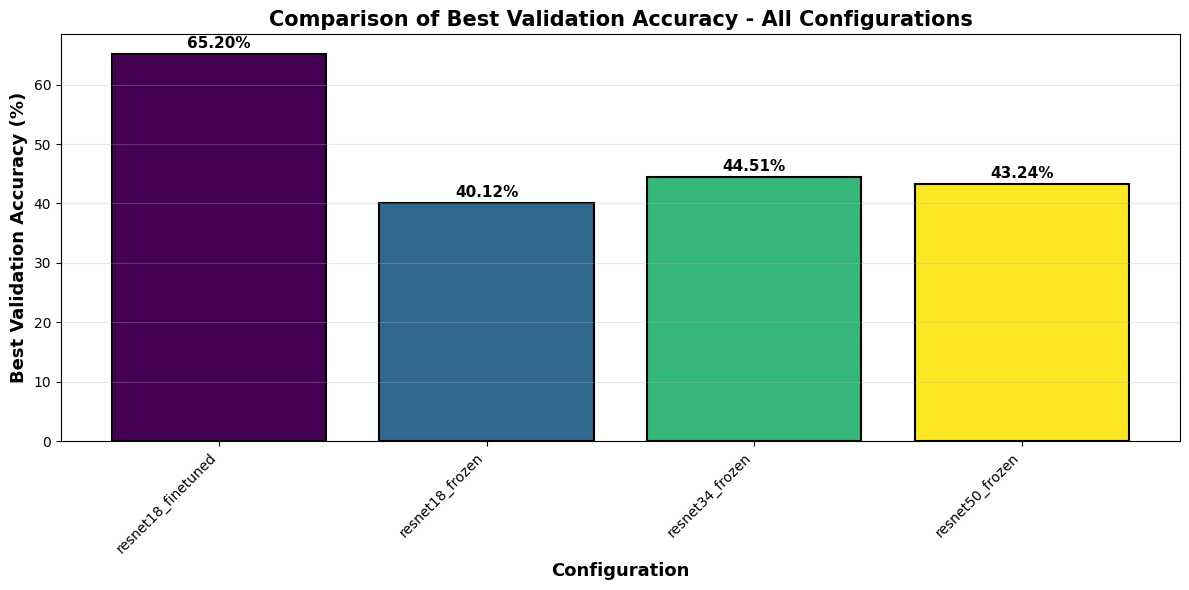

In [20]:
plot_all_histories(
        checkpoint_dir='./checkpoints/Transfer_learning_CNN',
        save_path='./checkpoints/Transfer_learning_CNN/all_histories_comparison.png'
    )

# Plotta bar chart con best accuracies
plot_final_comparison(
    checkpoint_dir='./checkpoints/Transfer_learning_CNN',
    save_path='./checkpoints/Transfer_learning_CNN/final_comparison.png'
)

# Dataset piu' grande: CelebA, con kaggle

In [21]:
def setup_kaggle_and_download_celeba(kaggle_username=None, kaggle_key=None,
                                     data_dir='./content/data/celeba'):
    """
    Setup Kaggle e scarica CelebA dataset

    PREREQUISITI:
    1. Vai su https://www.kaggle.com/settings
    2. Scroll down a "API" section
    3. Click "Create New API Token"
    4. Copia USERNAME e KEY dal token mostrato

    Args:
        kaggle_username: tuo username Kaggle
        kaggle_key: tuo API key Kaggle
        data_dir: directory dove estrarre il dataset

    Returns:
        path del dataset estratto
    """
    import subprocess
    import os
    import json

    print("="*70)
    print("SETUP KAGGLE API")
    print("="*70)

    # Installa kaggle
    print("\n1. Installazione Kaggle API...")
    subprocess.run(['pip', 'install', '-q', 'kaggle'], check=True)
    print("   ✓ Kaggle API installato")

    # Setup credenziali
    print("\n2. Setup credenziali...")
    kaggle_dir = os.path.expanduser('~/.kaggle')
    os.makedirs(kaggle_dir, exist_ok=True)

    # Opzione 1: usa username e key forniti
    if kaggle_username and kaggle_key:
        print("   ✓ Credenziali fornite direttamente")
        kaggle_json = {
            "username": kaggle_username,
            "key": kaggle_key
        }

        with open(f'{kaggle_dir}/kaggle.json', 'w') as f:
            json.dump(kaggle_json, f)

        subprocess.run(['chmod', '600', f'{kaggle_dir}/kaggle.json'], check=True)
        print("   ✓ Credenziali configurate")

    # Opzione 2: cerca kaggle.json già uploadato
    elif os.path.exists('/content/kaggle.json'):
        print("   ✓ kaggle.json trovato!")
        subprocess.run(['cp', '/content/kaggle.json', f'{kaggle_dir}/kaggle.json'], check=True)
        subprocess.run(['chmod', '600', f'{kaggle_dir}/kaggle.json'], check=True)
        print("   ✓ Credenziali configurate")

    else:
        print("\n    ERRORE: Credenziali non fornite!")
        print("\n   OPZIONE 1 - Passa username e key:")
        print("   setup_kaggle_and_download_celeba(")
        print("       kaggle_username='tuo_username',")
        print("       kaggle_key='tua_api_key'")
        print("   )")
        print("\n   OPZIONE 2 - Upload kaggle.json:")
        print("   1. Vai su https://www.kaggle.com/settings")
        print("   2. Scroll to 'API' section")
        print("   3. Click 'Create New API Token'")
        print("   4. Download kaggle.json")
        print("   5. Upload kaggle.json su Colab (sidebar Files)")
        print("   6. Riprova: setup_kaggle_and_download_celeba()")
        return None

    # Download dataset
    print("\n3. Download CelebA dataset...")
    print("   (Questo richiederà 3-5 minuti, ~1.5GB)")

    os.makedirs(data_dir, exist_ok=True)

    try:
        # Download
        subprocess.run([
            'kaggle', 'datasets', 'download', '-d',
            'jessicali9530/celeba-dataset',
            '-p', data_dir
        ], check=True)
        print("   ✓ Download completato!")

        # Unzip
        print("\n4. Estrazione archivio...")
        zip_file = os.path.join(data_dir, 'celeba-dataset.zip')
        subprocess.run(['unzip', '-q', zip_file, '-d', data_dir], check=True)

        # Rimuovi zip
        os.remove(zip_file)
        print("   ✓ Dataset estratto!")

        print("\n" + "="*70)
        print("✓ CELEBA PRONTO!")
        print(f"  Path: {data_dir}")
        print("="*70 + "\n")

        return data_dir

    except subprocess.CalledProcessError as e:
        print(f"\n    Errore durante download: {e}")
        print("   Verifica le credenziali Kaggle")
        return None


def load_celeba_from_kaggle(data_dir='/content/data/celeba', img_size=128,
                            batch_size=64, augment=True, test_split=0.2,
                            max_samples=10000):
    """
    Carica CelebA da dataset Kaggle - VERSIONE OTTIMIZZATA
    
    Ottimizzazioni principali:
    - Lettura CSV vettorizzata (no loop)
    - Pre-filtraggio immagini esistenti
    - Caching delle trasformazioni
    - Prefetching dati
    """
    import pandas as pd
    from collections import Counter
    import numpy as np

    print("Caricamento CelebA da Kaggle (ottimizzato)...")

    # Path del dataset
    img_dir = os.path.join(data_dir, 'img_align_celeba', 'img_align_celeba')
    attr_file = os.path.join(data_dir, 'list_attr_celeba.csv')

    # Controlla esistenza
    if not os.path.exists(img_dir):
        print(f"❌ Immagini non trovate in {img_dir}")
        return None, None, None
    if not os.path.exists(attr_file):
        print(f"❌ Attributi non trovati in {attr_file}")
        return None, None, None

    print("  ✓ Dataset trovato!")

    # 🚀 OTTIMIZZAZIONE 1: Leggi CSV con dtype ottimizzati
    print("  Lettura attributi...")
    df_attr = pd.read_csv(attr_file, dtype={'image_id': 'string'})
    
    # Converti colonne attributi a int8 (risparmio memoria)
    attr_cols = [c for c in df_attr.columns if c != 'image_id']
    for col in attr_cols:
        df_attr[col] = df_attr[col].astype('int8')

    # 🚀 OTTIMIZZAZIONE 2: Pre-filtra solo immagini che esistono
    print("  Filtraggio immagini esistenti...")
    all_images = sorted(os.listdir(img_dir))[:max_samples] if max_samples else sorted(os.listdir(img_dir))
    
    # Converti a set per lookup veloce O(1)
    existing_images = set(all_images)
    
    # Filtra DataFrame solo per immagini che esistono
    df_attr = df_attr[df_attr['image_id'].isin(existing_images)].reset_index(drop=True)
    
    print(f"  Samples validi: {len(df_attr)}")

    # 🚀 OTTIMIZZAZIONE 3: Calcolo labels vettorizzato (no loop!)
    print("  Creazione classi (vettorizzato)...")
    
    # Estrai attributi come array numpy
    male = (df_attr['Male'].values == 1).astype(np.int32)
    young = (df_attr['Young'].values == 1).astype(np.int32)
    smiling = (df_attr['Smiling'].values == 1).astype(np.int32)
    eyeglasses = (df_attr['Eyeglasses'].values == 1).astype(np.int32)
    
    # Calcolo vettorizzato delle labels
    labels = male * 8 + young * 4 + smiling * 2 + eyeglasses
    
    # Crea paths completi
    images_paths = [os.path.join(img_dir, img_id) for img_id in df_attr['image_id'].values]
    
    num_classes = len(np.unique(labels))
    print(f"  Classi create: {num_classes}")
    
    label_dist = Counter(labels)
    print(f"  Distribuzione (top 5): {label_dist.most_common(5)}")

    # Split train/test stratificato
    train_paths, test_paths, train_labels, test_labels = train_test_split(
        images_paths, labels,
        test_size=test_split,
        stratify=labels,
        random_state=42
    )

    # Crea transforms
    train_transform, test_transform = get_data_transforms(img_size, augment)

    # 🚀 OTTIMIZZAZIONE 4: Dataset con caching opzionale
    class CelebAOptimizedDataset(Dataset):
        def __init__(self, image_paths, labels, transform, cache_in_memory=False):
            self.image_paths = image_paths
            self.labels = labels
            self.transform = transform
            self.cache = {} if cache_in_memory else None

        def __len__(self):
            return len(self.image_paths)

        def __getitem__(self, idx):
            label = int(self.labels[idx])  # Assicura tipo int nativo
            
            # Usa cache se abilitata
            if self.cache is not None:
                if idx in self.cache:
                    img = self.cache[idx]
                else:
                    img = Image.open(self.image_paths[idx]).convert('RGB')
                    self.cache[idx] = img
            else:
                img = Image.open(self.image_paths[idx]).convert('RGB')

            if self.transform:
                img = self.transform(img)

            return img, torch.tensor(label, dtype=torch.long)

    # Cache solo se dataset piccolo (< 5000 immagini)
    cache_enabled = len(train_paths) < 5000
    
    train_dataset = CelebAOptimizedDataset(train_paths, train_labels, 
                                          train_transform, cache_in_memory=cache_enabled)
    test_dataset = CelebAOptimizedDataset(test_paths, test_labels, 
                                         test_transform, cache_in_memory=False)

    # 🚀 OTTIMIZZAZIONE 5: DataLoaders con prefetching
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,  # Aumenta se hai più CPU
        pin_memory=True,
        persistent_workers=True,  # Riusa workers
        prefetch_factor=2  # Prefetch 2 batch
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True,
        persistent_workers=True,
        prefetch_factor=2
    )

    print(f"\n✓ DataLoaders CelebA ottimizzati:")
    print(f"  Train samples: {len(train_dataset)}")
    print(f"  Test samples: {len(test_dataset)}")
    print(f"  Num classes: {num_classes}")
    print(f"  Batch size: {batch_size}")
    print(f"  Cache attiva: {'Sì' if cache_enabled else 'No'}")
    print(f"\n  NOTA: Classi create da attributi (Male/Young/Smiling/Eyeglasses)\n")

    return train_loader, test_loader, num_classes

setup Kaggle

In [49]:
setup_kaggle_and_download_celeba(
    kaggle_username='mrmoro',
    kaggle_key='KGAT_52381a474ad3b79ffab01ccf5632c3bc'
)

SETUP KAGGLE API

1. Installazione Kaggle API...
   ✓ Kaggle API installato

2. Setup credenziali...
   ✓ Credenziali fornite direttamente
   ✓ Credenziali configurate

3. Download CelebA dataset...
   (Questo richiederà 3-5 minuti, ~1.5GB)
Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
celeba-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
   ✓ Download completato!

4. Estrazione archivio...
   ✓ Dataset estratto!

✓ CELEBA PRONTO!
  Path: ./content/data/celeba



'./content/data/celeba'

Scarica il dataset

In [22]:
train_loader, test_loader, num_classes = load_celeba_from_kaggle(
    data_dir='./content/data/celeba',
    img_size=128,
    batch_size=128,
    max_samples=202599  # Limita a 10k per velocità
)

Caricamento CelebA da Kaggle (ottimizzato)...
  ✓ Dataset trovato!
  Lettura attributi...
  Filtraggio immagini esistenti...
  Samples validi: 202599
  Creazione classi (vettorizzato)...
  Classi create: 16
  Distribuzione (top 5): [(np.int32(6), 52962), (np.int32(4), 48603), (np.int32(12), 30405), (np.int32(14), 19260), (np.int32(8), 13770)]

✓ DataLoaders CelebA ottimizzati:
  Train samples: 162079
  Test samples: 40520
  Num classes: 16
  Batch size: 128
  Cache attiva: No

  NOTA: Classi create da attributi (Male/Young/Smiling/Eyeglasses)



# Modello deep con skip conenction con dataset grande

## Ricreo config cnn con quelle piu' interessanti

In [25]:
def get_cnn_configs():
    """
    Configurazioni CNN dalla più semplice alla più ottimizzata

    Returns:
        dict con tutte le configurazioni
    """
    configs = {
        # 1. Baseline CNN - configurazione base
        'cnn_baseline': {
            'model_config': {
                'input_channels': 3,
                'num_filters': [32, 64, 128],  # 3 conv blocks
                'kernel_sizes': [3, 3, 3],
                'fc_hidden_size': 512,
                'embedding_size': 128,
                'dropout_rate': 0.5,
                'use_batchnorm': True,
                'use_global_avg_pool': False
            },
            'training_config': {
                'learning_rate': 1e-3,
                'batch_size': 64,
                'num_epochs': 30,
                'optimizer': 'adam',
                'weight_decay': 0.0,
                'label_smoothing': 0.0,
                'early_stopping_patience': 6
               }
        },

        # 2. Shallow CNN - meno layer convoluzionali
        'cnn_shallow': {
            'model_config': {
                'input_channels': 3,
                'num_filters': [32, 64],  # Solo 2 conv blocks
                'kernel_sizes': [3, 3],
                'fc_hidden_size': 512,
                'embedding_size': 128,
                'dropout_rate': 0.4,
                'use_batchnorm': True,
                'use_global_avg_pool': False
            },
            'training_config': {
                'learning_rate': 1e-3,
                'batch_size': 64,
                'num_epochs': 30,
                'optimizer': 'adam',
                'weight_decay': 0.0,
                'label_smoothing': 0.0,
                'early_stopping_patience': 6
            }
        },

        # 3. Deep CNN - più layer convoluzionali
        'cnn_deep': {
            'model_config': {
                'input_channels': 3,
                'num_filters': [32, 64, 128, 256],  # 4 conv blocks
                'kernel_sizes': [3, 3, 3, 3],
                'fc_hidden_size': 1024,
                'embedding_size': 256,
                'dropout_rate': 0.4,
                'use_batchnorm': True,
                'use_global_avg_pool': False
            },
            'training_config': {
                'learning_rate': 5e-4,  # LR più basso per deep
                'batch_size': 32,  # Batch più piccolo
                'num_epochs': 30,
                'optimizer': 'adam',
                'weight_decay': 1e-5,
                'label_smoothing': 0.05,
                'early_stopping_patience': 6
            }
        },

        # 5. Global Average Pooling - riduce parametri
        'cnn_gap': {
            'model_config': {
                'input_channels': 3,
                'num_filters': [64, 128, 256],
                'kernel_sizes': [3, 3, 3],
                'fc_hidden_size': 512,
                'embedding_size': 128,
                'dropout_rate': 0.4,
                'use_batchnorm': True,
                'use_global_avg_pool': True  # Usa GAP
            },
            'training_config': {
                'learning_rate': 1e-3,
                'batch_size': 64,
                'num_epochs': 30,
                'optimizer': 'adam',
                'weight_decay': 1e-5,
                'label_smoothing': 0.0,
                'early_stopping_patience': 6
            }
        },

        # 6. Optimized CNN - best practices
        'cnn_optimized': {
            'model_config': {
                'input_channels': 3,
                'num_filters': [64, 128, 256, 512],  # Progressione standard
                'kernel_sizes': [3, 3, 3, 3],
                'fc_hidden_size': 1024,
                'embedding_size': 256,
                'dropout_rate': 0.3,
                'use_batchnorm': True,
                'use_global_avg_pool': False,  
                'use_residual': False
            },
            'training_config': {
                'learning_rate': 5e-4,
                'batch_size': 64,
                'num_epochs': 30,
                'optimizer': 'adam',
                'weight_decay': 1e-4,  # L2 reg
                'label_smoothing': 0.1,  # Label smoothing
                'early_stopping_patience': 6
            }
        },

        # 7. Deep Residual CNN - rete profonda con skip connections
        'cnn_deep_residual': {
            'model_config': {
                'input_channels': 3,
                'num_filters': [64, 64, 128, 128, 256, 256],  # 6 residual blocks
                'kernel_sizes': [3, 3, 3, 3, 3, 3],
                'fc_hidden_size': 1024,
                'embedding_size': 256,
                'dropout_rate': 0.3,
                'use_batchnorm': True,
                'use_global_avg_pool': False,
                'use_residual': True  # Skip connections attive
            },
            'training_config': {
                'learning_rate': 3e-4,  # LR più basso per deep residual
                'batch_size': 32,
                'num_epochs': 30,
                'optimizer': 'adam',
                'weight_decay': 1e-4,
                'label_smoothing': 0.1,
                'early_stopping_patience': 6
            }
        }
    }

    return configs

## CNN su CelebA

> Importante: le classi sono cambiate, quindi i valori potrebbero piú alti non necessariamente significano una rete davvero migliore <br>
> Cambiato classi perché il dataset forniva tali labels



In [23]:
# Train tutte le configurazioni
results = train_multiple_configs(
    model_class=create_cnn_model,
    train_loader=train_loader,
    test_loader=test_loader,
    num_classes=num_classes,
    checkpoint_dir='./checkpoints/Transfer_learning_celeba_CNN',
    device=None
)


Starting training: resnet18_frozen


TRAINING: resnet18_frozen
Model config: {'use_pretrained_resnet': True, 'resnet_version': 'resnet18', 'freeze_resnet_backbone': True, 'num_filters': [256, 256], 'kernel_sizes': [3, 3], 'fc_hidden_size': 512, 'embedding_size': 128, 'num_classes': 16, 'dropout_rate': 0.3, 'use_batchnorm': True, 'use_global_avg_pool': True}
Training config: {'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 35, 'optimizer': 'adam', 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'early_stopping_patience': 8}


Epoch 1/35
----------------------------------------------------------------------


/root/Git/Progetto_DeepLearning_e_architetture_di_Reti_Neurali/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/Git/Progetto_DeepLearning_e_architetture_di_Reti_Neurali/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Validation: 100%|██████████| 317/317 [00:33<00:00,  9.55it/s, loss=1.6357, acc=56.79%]



Epoch 1 Summary:
  Train Loss: 1.5989 | Train Acc: 54.77%
  Val Loss: 1.5308 | Val Acc: 56.79%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet18_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 56.79% ***

Epoch 2/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:28<00:00, 10.94it/s, loss=1.5799, acc=59.19%]



Epoch 2 Summary:
  Train Loss: 1.5183 | Train Acc: 58.14%
  Val Loss: 1.4904 | Val Acc: 59.19%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet18_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 59.19% ***

Epoch 3/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:28<00:00, 10.99it/s, loss=1.5391, acc=59.88%]



Epoch 3 Summary:
  Train Loss: 1.4924 | Train Acc: 59.36%
  Val Loss: 1.4639 | Val Acc: 59.88%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet18_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 59.88% ***

Epoch 4/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.92it/s, loss=1.5578, acc=60.51%]



Epoch 4 Summary:
  Train Loss: 1.4773 | Train Acc: 59.94%
  Val Loss: 1.4553 | Val Acc: 60.51%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet18_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 60.51% ***

Epoch 5/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.89it/s, loss=1.5289, acc=60.02%]



Epoch 5 Summary:
  Train Loss: 1.4668 | Train Acc: 60.37%
  Val Loss: 1.4589 | Val Acc: 60.02%
  EarlyStopping counter: 1/8

Epoch 6/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.91it/s, loss=1.6389, acc=60.23%]



Epoch 6 Summary:
  Train Loss: 1.4587 | Train Acc: 60.68%
  Val Loss: 1.4581 | Val Acc: 60.23%
  EarlyStopping counter: 2/8

Epoch 7/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.85it/s, loss=1.5700, acc=60.95%]



Epoch 7 Summary:
  Train Loss: 1.4499 | Train Acc: 61.09%
  Val Loss: 1.4441 | Val Acc: 60.95%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet18_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 60.95% ***

Epoch 8/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.79it/s, loss=1.5714, acc=61.20%]



Epoch 8 Summary:
  Train Loss: 1.4462 | Train Acc: 61.15%
  Val Loss: 1.4347 | Val Acc: 61.20%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet18_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 61.20% ***

Epoch 9/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:28<00:00, 10.97it/s, loss=1.4808, acc=61.56%]



Epoch 9 Summary:
  Train Loss: 1.4417 | Train Acc: 61.33%
  Val Loss: 1.4347 | Val Acc: 61.56%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet18_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 61.56% ***

Epoch 10/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:28<00:00, 10.96it/s, loss=1.5977, acc=61.54%]



Epoch 10 Summary:
  Train Loss: 1.4371 | Train Acc: 61.53%
  Val Loss: 1.4316 | Val Acc: 61.54%
  EarlyStopping counter: 1/8

Epoch 11/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.93it/s, loss=1.5572, acc=61.47%]



Epoch 11 Summary:
  Train Loss: 1.4342 | Train Acc: 61.68%
  Val Loss: 1.4297 | Val Acc: 61.47%
  EarlyStopping counter: 2/8

Epoch 12/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.92it/s, loss=1.4762, acc=61.64%]



Epoch 12 Summary:
  Train Loss: 1.4312 | Train Acc: 61.83%
  Val Loss: 1.4272 | Val Acc: 61.64%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet18_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 61.64% ***

Epoch 13/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.92it/s, loss=1.4947, acc=61.96%]



Epoch 13 Summary:
  Train Loss: 1.4289 | Train Acc: 61.85%
  Val Loss: 1.4161 | Val Acc: 61.96%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet18_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 61.96% ***

Epoch 14/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.87it/s, loss=1.5085, acc=61.93%]



Epoch 14 Summary:
  Train Loss: 1.4246 | Train Acc: 62.13%
  Val Loss: 1.4243 | Val Acc: 61.93%
  EarlyStopping counter: 1/8

Epoch 15/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.88it/s, loss=1.5885, acc=62.27%]



Epoch 15 Summary:
  Train Loss: 1.4217 | Train Acc: 62.25%
  Val Loss: 1.4178 | Val Acc: 62.27%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet18_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 62.27% ***

Epoch 16/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:28<00:00, 10.94it/s, loss=1.5157, acc=61.92%]



Epoch 16 Summary:
  Train Loss: 1.4158 | Train Acc: 62.56%
  Val Loss: 1.4212 | Val Acc: 61.92%
  EarlyStopping counter: 1/8

Epoch 17/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:30<00:00, 10.34it/s, loss=1.4967, acc=62.77%]



Epoch 17 Summary:
  Train Loss: 1.4106 | Train Acc: 62.67%
  Val Loss: 1.4065 | Val Acc: 62.77%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet18_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 62.77% ***

Epoch 18/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.90it/s, loss=1.4827, acc=63.20%]



Epoch 18 Summary:
  Train Loss: 1.4075 | Train Acc: 62.98%
  Val Loss: 1.3973 | Val Acc: 63.20%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet18_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 63.20% ***

Epoch 19/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.92it/s, loss=1.5012, acc=63.26%]



Epoch 19 Summary:
  Train Loss: 1.4018 | Train Acc: 63.16%
  Val Loss: 1.3954 | Val Acc: 63.26%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet18_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 63.26% ***

Epoch 20/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:28<00:00, 10.99it/s, loss=1.5179, acc=62.95%]



Epoch 20 Summary:
  Train Loss: 1.3983 | Train Acc: 63.31%
  Val Loss: 1.4083 | Val Acc: 62.95%
  EarlyStopping counter: 1/8

Epoch 21/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.88it/s, loss=1.4629, acc=62.06%]



Epoch 21 Summary:
  Train Loss: 1.3992 | Train Acc: 63.23%
  Val Loss: 1.4102 | Val Acc: 62.06%
  EarlyStopping counter: 2/8

Epoch 22/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.90it/s, loss=1.4901, acc=63.68%]



Epoch 22 Summary:
  Train Loss: 1.3966 | Train Acc: 63.36%
  Val Loss: 1.3892 | Val Acc: 63.68%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet18_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 63.68% ***

Epoch 23/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.92it/s, loss=1.5007, acc=63.37%]



Epoch 23 Summary:
  Train Loss: 1.3952 | Train Acc: 63.43%
  Val Loss: 1.3975 | Val Acc: 63.37%
  EarlyStopping counter: 1/8

Epoch 24/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:28<00:00, 10.95it/s, loss=1.5248, acc=62.77%]



Epoch 24 Summary:
  Train Loss: 1.3941 | Train Acc: 63.43%
  Val Loss: 1.4037 | Val Acc: 62.77%
  EarlyStopping counter: 2/8

Epoch 25/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.87it/s, loss=1.4069, acc=63.20%]



Epoch 25 Summary:
  Train Loss: 1.3927 | Train Acc: 63.43%
  Val Loss: 1.3894 | Val Acc: 63.20%
  EarlyStopping counter: 3/8

Epoch 26/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.93it/s, loss=1.4714, acc=64.22%]



Epoch 26 Summary:
  Train Loss: 1.3710 | Train Acc: 64.42%
  Val Loss: 1.3737 | Val Acc: 64.22%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet18_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 64.22% ***

Epoch 27/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:28<00:00, 10.99it/s, loss=1.4499, acc=64.61%]



Epoch 27 Summary:
  Train Loss: 1.3623 | Train Acc: 64.83%
  Val Loss: 1.3642 | Val Acc: 64.61%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet18_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 64.61% ***

Epoch 28/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.92it/s, loss=1.4649, acc=64.33%]



Epoch 28 Summary:
  Train Loss: 1.3577 | Train Acc: 65.08%
  Val Loss: 1.3728 | Val Acc: 64.33%
  EarlyStopping counter: 1/8

Epoch 29/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.91it/s, loss=1.4430, acc=64.45%]



Epoch 29 Summary:
  Train Loss: 1.3547 | Train Acc: 65.08%
  Val Loss: 1.3654 | Val Acc: 64.45%
  EarlyStopping counter: 2/8

Epoch 30/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.92it/s, loss=1.4485, acc=64.72%]



Epoch 30 Summary:
  Train Loss: 1.3531 | Train Acc: 65.13%
  Val Loss: 1.3612 | Val Acc: 64.72%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet18_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 64.72% ***

Epoch 31/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:28<00:00, 10.98it/s, loss=1.4846, acc=64.09%]



Epoch 31 Summary:
  Train Loss: 1.3522 | Train Acc: 65.16%
  Val Loss: 1.3689 | Val Acc: 64.09%
  EarlyStopping counter: 1/8

Epoch 32/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.89it/s, loss=1.5081, acc=64.72%]



Epoch 32 Summary:
  Train Loss: 1.3489 | Train Acc: 65.40%
  Val Loss: 1.3583 | Val Acc: 64.72%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet18_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 64.72% ***

Epoch 33/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.84it/s, loss=1.4520, acc=64.01%]



Epoch 33 Summary:
  Train Loss: 1.3480 | Train Acc: 65.41%
  Val Loss: 1.3800 | Val Acc: 64.01%
  EarlyStopping counter: 1/8

Epoch 34/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:28<00:00, 10.96it/s, loss=1.4666, acc=65.19%]



Epoch 34 Summary:
  Train Loss: 1.3329 | Train Acc: 66.01%
  Val Loss: 1.3471 | Val Acc: 65.19%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet18_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 65.19% ***

Epoch 35/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.85it/s, loss=1.4926, acc=64.83%]



Epoch 35 Summary:
  Train Loss: 1.3239 | Train Acc: 66.29%
  Val Loss: 1.3562 | Val Acc: 64.83%
  EarlyStopping counter: 1/8
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet18_frozen/last_checkpoint.pth

TRAINING COMPLETATO: resnet18_frozen
Best Validation Accuracy: 65.19%


Starting FINE-TUNING phase: resnet18_frozen

Backbone scongelato per fine-tuning
Using device: cuda
Transfer learning: backbone LR=0.000000, nuovi layer LR=0.000010

INIZIO TRAINING


Epoch 1/5
------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:28<00:00, 10.97it/s, loss=1.1592, acc=65.96%]



Epoch 1 Summary:
  Train Loss: 0.9711 | Train Acc: 67.05%
  Val Loss: 0.9865 | Val Acc: 65.96%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet18_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 65.96% ***
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet18_frozen/last_checkpoint.pth

Epoch 2/5
------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.91it/s, loss=1.1311, acc=66.17%]



Epoch 2 Summary:
  Train Loss: 0.9412 | Train Acc: 67.54%
  Val Loss: 0.9700 | Val Acc: 66.17%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet18_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 66.17% ***
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet18_frozen/last_checkpoint.pth

Epoch 3/5
------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.89it/s, loss=1.1421, acc=66.81%]



Epoch 3 Summary:
  Train Loss: 0.9192 | Train Acc: 67.97%
  Val Loss: 0.9478 | Val Acc: 66.81%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet18_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 66.81% ***
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet18_frozen/last_checkpoint.pth

Epoch 4/5
------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.93it/s, loss=1.0959, acc=67.19%]



Epoch 4 Summary:
  Train Loss: 0.9045 | Train Acc: 68.36%
  Val Loss: 0.9326 | Val Acc: 67.19%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet18_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 67.19% ***
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet18_frozen/last_checkpoint.pth

Epoch 5/5
------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.89it/s, loss=1.0915, acc=67.38%]



Epoch 5 Summary:
  Train Loss: 0.8927 | Train Acc: 68.62%
  Val Loss: 0.9255 | Val Acc: 67.38%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet18_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 67.38% ***
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet18_frozen/last_checkpoint.pth

TRAINING COMPLETATO
Best Validation Accuracy: 67.38%

Fine-tuning migliorato: 67.38%

Starting training: resnet18_finetuned


TRAINING: resnet18_finetuned
Model config: {'use_pretrained_resnet': True, 'resnet_version': 'resnet18', 'freeze_resnet_backbone': False, 'num_filters': [256, 256], 'kernel_sizes': [3, 3], 'fc_hidden_size': 512, 'embedding_size': 128, 'num_classes': 16, 'dropout_rate': 0.3, 'use_batchnorm': True, 'use_global_avg_pool': True}
Training config: {'learning_rate': 0.0001, 'batch_size': 32, 'num_epochs': 35, 'optimizer': 'adam', 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'early_stopping_patience': 8}


Epoch 1/35
---------------------

Validation: 100%|██████████| 317/317 [00:29<00:00, 10.89it/s, loss=1.1496, acc=78.95%]



Epoch 1 Summary:
  Train Loss: 1.1962 | Train Acc: 74.27%
  Val Loss: 1.0287 | Val Acc: 78.95%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet18_finetuned/best_model.pth
  *** Nuovo best model! Accuracy: 78.95% ***

Epoch 2/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:28<00:00, 10.99it/s, loss=1.1002, acc=81.04%]



Epoch 2 Summary:
  Train Loss: 1.0162 | Train Acc: 79.91%
  Val Loss: 0.9839 | Val Acc: 81.04%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet18_finetuned/best_model.pth
  *** Nuovo best model! Accuracy: 81.04% ***

Epoch 3/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.85it/s, loss=1.0580, acc=81.16%]



Epoch 3 Summary:
  Train Loss: 0.9887 | Train Acc: 80.94%
  Val Loss: 0.9736 | Val Acc: 81.16%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet18_finetuned/best_model.pth
  *** Nuovo best model! Accuracy: 81.16% ***

Epoch 4/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:28<00:00, 10.94it/s, loss=1.0834, acc=81.69%]



Epoch 4 Summary:
  Train Loss: 0.9690 | Train Acc: 81.77%
  Val Loss: 0.9686 | Val Acc: 81.69%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet18_finetuned/best_model.pth
  *** Nuovo best model! Accuracy: 81.69% ***

Epoch 5/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:28<00:00, 10.95it/s, loss=1.0490, acc=81.89%]



Epoch 5 Summary:
  Train Loss: 0.9553 | Train Acc: 82.42%
  Val Loss: 0.9647 | Val Acc: 81.89%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet18_finetuned/best_model.pth
  *** Nuovo best model! Accuracy: 81.89% ***

Epoch 6/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.87it/s, loss=1.1364, acc=81.24%]



Epoch 6 Summary:
  Train Loss: 0.9396 | Train Acc: 83.05%
  Val Loss: 0.9795 | Val Acc: 81.24%
  EarlyStopping counter: 1/8

Epoch 7/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:28<00:00, 10.95it/s, loss=1.0934, acc=82.17%]



Epoch 7 Summary:
  Train Loss: 0.9278 | Train Acc: 83.58%
  Val Loss: 0.9619 | Val Acc: 82.17%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet18_finetuned/best_model.pth
  *** Nuovo best model! Accuracy: 82.17% ***

Epoch 8/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:28<00:00, 10.96it/s, loss=1.0865, acc=81.65%]



Epoch 8 Summary:
  Train Loss: 0.9147 | Train Acc: 84.24%
  Val Loss: 0.9764 | Val Acc: 81.65%
  EarlyStopping counter: 1/8

Epoch 9/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.93it/s, loss=1.1444, acc=82.23%]



Epoch 9 Summary:
  Train Loss: 0.9005 | Train Acc: 84.79%
  Val Loss: 0.9671 | Val Acc: 82.23%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet18_finetuned/best_model.pth
  *** Nuovo best model! Accuracy: 82.23% ***

Epoch 10/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.88it/s, loss=1.1235, acc=82.16%]



Epoch 10 Summary:
  Train Loss: 0.8870 | Train Acc: 85.45%
  Val Loss: 0.9740 | Val Acc: 82.16%
  EarlyStopping counter: 1/8

Epoch 11/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.86it/s, loss=1.1045, acc=80.55%]



Epoch 11 Summary:
  Train Loss: 0.8742 | Train Acc: 86.01%
  Val Loss: 0.9962 | Val Acc: 80.55%
  EarlyStopping counter: 2/8

Epoch 12/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.85it/s, loss=1.0802, acc=81.20%]



Epoch 12 Summary:
  Train Loss: 0.8603 | Train Acc: 86.68%
  Val Loss: 0.9838 | Val Acc: 81.20%
  EarlyStopping counter: 3/8

Epoch 13/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.88it/s, loss=1.1681, acc=82.42%]



Epoch 13 Summary:
  Train Loss: 0.8141 | Train Acc: 88.90%
  Val Loss: 0.9913 | Val Acc: 82.42%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet18_finetuned/best_model.pth
  *** Nuovo best model! Accuracy: 82.42% ***

Epoch 14/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:28<00:00, 10.95it/s, loss=1.0459, acc=81.98%]



Epoch 14 Summary:
  Train Loss: 0.7914 | Train Acc: 90.11%
  Val Loss: 0.9958 | Val Acc: 81.98%
  EarlyStopping counter: 1/8

Epoch 15/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.85it/s, loss=1.1154, acc=82.17%]



Epoch 15 Summary:
  Train Loss: 0.7735 | Train Acc: 90.86%
  Val Loss: 1.0245 | Val Acc: 82.17%
  EarlyStopping counter: 2/8

Epoch 16/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.83it/s, loss=1.2038, acc=81.97%]



Epoch 16 Summary:
  Train Loss: 0.7594 | Train Acc: 91.58%
  Val Loss: 1.0270 | Val Acc: 81.97%
  EarlyStopping counter: 3/8

Epoch 17/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.92it/s, loss=1.1438, acc=81.98%]



Epoch 17 Summary:
  Train Loss: 0.7277 | Train Acc: 93.15%
  Val Loss: 1.0485 | Val Acc: 81.98%
  EarlyStopping counter: 4/8

Epoch 18/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.90it/s, loss=1.1263, acc=82.02%]



Epoch 18 Summary:
  Train Loss: 0.7140 | Train Acc: 93.77%
  Val Loss: 1.0612 | Val Acc: 82.02%
  EarlyStopping counter: 5/8

Epoch 19/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:28<00:00, 10.96it/s, loss=1.0665, acc=81.67%]



Epoch 19 Summary:
  Train Loss: 0.7022 | Train Acc: 94.37%
  Val Loss: 1.0696 | Val Acc: 81.67%
  EarlyStopping counter: 6/8

Epoch 20/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.86it/s, loss=1.1573, acc=82.01%]



Epoch 20 Summary:
  Train Loss: 0.6835 | Train Acc: 95.21%
  Val Loss: 1.0842 | Val Acc: 82.01%
  EarlyStopping counter: 7/8

Epoch 21/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:28<00:00, 10.97it/s, loss=1.1533, acc=81.72%]
/root/Git/Progetto_DeepLearning_e_architetture_di_Reti_Neurali/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 21 Summary:
  Train Loss: 0.6739 | Train Acc: 95.69%
  Val Loss: 1.0987 | Val Acc: 81.72%
  EarlyStopping counter: 8/8
  Early stopping triggered!

Early stopping at epoch 21
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet18_finetuned/last_checkpoint.pth

TRAINING COMPLETATO: resnet18_finetuned
Best Validation Accuracy: 82.42%


Starting training: resnet34_frozen


TRAINING: resnet34_frozen
Model config: {'use_pretrained_resnet': True, 'resnet_version': 'resnet34', 'freeze_resnet_backbone': True, 'num_filters': [384, 256], 'kernel_sizes': [3, 3], 'fc_hidden_size': 768, 'embedding_size': 256, 'num_classes': 16, 'dropout_rate': 0.3, 'use_batchnorm': True, 'use_global_avg_pool': True}
Training config: {'learning_rate': 0.001, 'batch_size': 48, 'num_epochs': 35, 'optimizer': 'adam', 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'early_stopping_patience': 8}


Epoch 1/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:28<00:00, 10.97it/s, loss=1.6628, acc=57.97%]



Epoch 1 Summary:
  Train Loss: 1.5914 | Train Acc: 54.57%
  Val Loss: 1.5062 | Val Acc: 57.97%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 57.97% ***

Epoch 2/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.91it/s, loss=1.5750, acc=60.04%]



Epoch 2 Summary:
  Train Loss: 1.4973 | Train Acc: 59.00%
  Val Loss: 1.4595 | Val Acc: 60.04%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 60.04% ***

Epoch 3/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:28<00:00, 10.95it/s, loss=1.5924, acc=61.50%]



Epoch 3 Summary:
  Train Loss: 1.4605 | Train Acc: 60.56%
  Val Loss: 1.4372 | Val Acc: 61.50%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 61.50% ***

Epoch 4/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.80it/s, loss=1.5258, acc=62.62%]



Epoch 4 Summary:
  Train Loss: 1.4316 | Train Acc: 61.86%
  Val Loss: 1.4054 | Val Acc: 62.62%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 62.62% ***

Epoch 5/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.84it/s, loss=1.4344, acc=63.89%]



Epoch 5 Summary:
  Train Loss: 1.4127 | Train Acc: 62.72%
  Val Loss: 1.3867 | Val Acc: 63.89%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 63.89% ***

Epoch 6/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:28<00:00, 10.94it/s, loss=1.5491, acc=63.64%]



Epoch 6 Summary:
  Train Loss: 1.3968 | Train Acc: 63.38%
  Val Loss: 1.3911 | Val Acc: 63.64%
  EarlyStopping counter: 1/8

Epoch 7/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:28<00:00, 10.95it/s, loss=1.5005, acc=63.53%]



Epoch 7 Summary:
  Train Loss: 1.3884 | Train Acc: 63.61%
  Val Loss: 1.3808 | Val Acc: 63.53%
  EarlyStopping counter: 2/8

Epoch 8/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.90it/s, loss=1.5126, acc=64.15%]



Epoch 8 Summary:
  Train Loss: 1.3837 | Train Acc: 63.83%
  Val Loss: 1.3722 | Val Acc: 64.15%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 64.15% ***

Epoch 9/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.90it/s, loss=1.4539, acc=64.64%]



Epoch 9 Summary:
  Train Loss: 1.3760 | Train Acc: 64.27%
  Val Loss: 1.3674 | Val Acc: 64.64%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 64.64% ***

Epoch 10/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.79it/s, loss=1.4396, acc=64.92%]



Epoch 10 Summary:
  Train Loss: 1.3723 | Train Acc: 64.37%
  Val Loss: 1.3595 | Val Acc: 64.92%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 64.92% ***

Epoch 11/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.83it/s, loss=1.4100, acc=64.67%]



Epoch 11 Summary:
  Train Loss: 1.3659 | Train Acc: 64.54%
  Val Loss: 1.3605 | Val Acc: 64.67%
  EarlyStopping counter: 1/8

Epoch 12/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.91it/s, loss=1.4884, acc=64.99%]



Epoch 12 Summary:
  Train Loss: 1.3620 | Train Acc: 64.71%
  Val Loss: 1.3524 | Val Acc: 64.99%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 64.99% ***

Epoch 13/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:28<00:00, 10.94it/s, loss=1.4091, acc=65.26%]



Epoch 13 Summary:
  Train Loss: 1.3592 | Train Acc: 64.79%
  Val Loss: 1.3495 | Val Acc: 65.26%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 65.26% ***

Epoch 14/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.89it/s, loss=1.3668, acc=65.13%]



Epoch 14 Summary:
  Train Loss: 1.3526 | Train Acc: 65.04%
  Val Loss: 1.3464 | Val Acc: 65.13%
  EarlyStopping counter: 1/8

Epoch 15/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.93it/s, loss=1.4562, acc=65.56%]



Epoch 15 Summary:
  Train Loss: 1.3501 | Train Acc: 65.25%
  Val Loss: 1.3397 | Val Acc: 65.56%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 65.56% ***

Epoch 16/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.87it/s, loss=1.3819, acc=65.24%]



Epoch 16 Summary:
  Train Loss: 1.3495 | Train Acc: 65.23%
  Val Loss: 1.3429 | Val Acc: 65.24%
  EarlyStopping counter: 1/8

Epoch 17/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:28<00:00, 10.93it/s, loss=1.4000, acc=65.68%]



Epoch 17 Summary:
  Train Loss: 1.3456 | Train Acc: 65.54%
  Val Loss: 1.3354 | Val Acc: 65.68%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 65.68% ***

Epoch 18/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.83it/s, loss=1.4050, acc=65.68%]



Epoch 18 Summary:
  Train Loss: 1.3421 | Train Acc: 65.63%
  Val Loss: 1.3315 | Val Acc: 65.68%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 65.68% ***

Epoch 19/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.87it/s, loss=1.4856, acc=65.34%]



Epoch 19 Summary:
  Train Loss: 1.3410 | Train Acc: 65.47%
  Val Loss: 1.3368 | Val Acc: 65.34%
  EarlyStopping counter: 1/8

Epoch 20/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.91it/s, loss=1.4346, acc=65.81%]



Epoch 20 Summary:
  Train Loss: 1.3379 | Train Acc: 65.59%
  Val Loss: 1.3308 | Val Acc: 65.81%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 65.81% ***

Epoch 21/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.88it/s, loss=1.4812, acc=65.46%]



Epoch 21 Summary:
  Train Loss: 1.3347 | Train Acc: 65.87%
  Val Loss: 1.3335 | Val Acc: 65.46%
  EarlyStopping counter: 1/8

Epoch 22/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.88it/s, loss=1.5119, acc=65.71%]



Epoch 22 Summary:
  Train Loss: 1.3346 | Train Acc: 65.77%
  Val Loss: 1.3280 | Val Acc: 65.71%
  EarlyStopping counter: 2/8

Epoch 23/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.87it/s, loss=1.4661, acc=65.75%]



Epoch 23 Summary:
  Train Loss: 1.3342 | Train Acc: 65.88%
  Val Loss: 1.3328 | Val Acc: 65.75%
  EarlyStopping counter: 3/8

Epoch 24/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:28<00:00, 10.97it/s, loss=1.4456, acc=66.56%]



Epoch 24 Summary:
  Train Loss: 1.3085 | Train Acc: 66.75%
  Val Loss: 1.3102 | Val Acc: 66.56%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 66.56% ***

Epoch 25/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.92it/s, loss=1.4136, acc=66.68%]



Epoch 25 Summary:
  Train Loss: 1.3000 | Train Acc: 67.31%
  Val Loss: 1.3080 | Val Acc: 66.68%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 66.68% ***

Epoch 26/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.84it/s, loss=1.3921, acc=66.87%]



Epoch 26 Summary:
  Train Loss: 1.2965 | Train Acc: 67.44%
  Val Loss: 1.3029 | Val Acc: 66.87%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 66.87% ***

Epoch 27/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.91it/s, loss=1.4879, acc=66.70%]



Epoch 27 Summary:
  Train Loss: 1.2950 | Train Acc: 67.49%
  Val Loss: 1.3107 | Val Acc: 66.70%
  EarlyStopping counter: 1/8

Epoch 28/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.81it/s, loss=1.3928, acc=66.80%]



Epoch 28 Summary:
  Train Loss: 1.2936 | Train Acc: 67.53%
  Val Loss: 1.3045 | Val Acc: 66.80%
  EarlyStopping counter: 2/8

Epoch 29/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.67it/s, loss=1.4605, acc=66.76%]



Epoch 29 Summary:
  Train Loss: 1.2924 | Train Acc: 67.63%
  Val Loss: 1.3083 | Val Acc: 66.76%
  EarlyStopping counter: 3/8

Epoch 30/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.89it/s, loss=1.4139, acc=67.31%]



Epoch 30 Summary:
  Train Loss: 1.2761 | Train Acc: 68.21%
  Val Loss: 1.2932 | Val Acc: 67.31%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 67.31% ***

Epoch 31/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.91it/s, loss=1.4171, acc=67.42%]



Epoch 31 Summary:
  Train Loss: 1.2702 | Train Acc: 68.45%
  Val Loss: 1.2906 | Val Acc: 67.42%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 67.42% ***

Epoch 32/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:28<00:00, 10.95it/s, loss=1.4440, acc=67.32%]



Epoch 32 Summary:
  Train Loss: 1.2673 | Train Acc: 68.63%
  Val Loss: 1.2950 | Val Acc: 67.32%
  EarlyStopping counter: 1/8

Epoch 33/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.90it/s, loss=1.4314, acc=67.67%]



Epoch 33 Summary:
  Train Loss: 1.2633 | Train Acc: 68.85%
  Val Loss: 1.2876 | Val Acc: 67.67%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 67.67% ***

Epoch 34/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:28<00:00, 10.97it/s, loss=1.4624, acc=67.31%]



Epoch 34 Summary:
  Train Loss: 1.2616 | Train Acc: 68.99%
  Val Loss: 1.2913 | Val Acc: 67.31%
  EarlyStopping counter: 1/8

Epoch 35/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:28<00:00, 10.94it/s, loss=1.4547, acc=67.54%]



Epoch 35 Summary:
  Train Loss: 1.2602 | Train Acc: 68.87%
  Val Loss: 1.2865 | Val Acc: 67.54%
  EarlyStopping counter: 2/8
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet34_frozen/last_checkpoint.pth

TRAINING COMPLETATO: resnet34_frozen
Best Validation Accuracy: 67.67%


Starting FINE-TUNING phase: resnet34_frozen

Backbone scongelato per fine-tuning
Using device: cuda
Transfer learning: backbone LR=0.000000, nuovi layer LR=0.000010

INIZIO TRAINING


Epoch 1/5
------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.91it/s, loss=1.0935, acc=68.21%]



Epoch 1 Summary:
  Train Loss: 0.8863 | Train Acc: 69.79%
  Val Loss: 0.9089 | Val Acc: 68.21%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 68.21% ***
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet34_frozen/last_checkpoint.pth

Epoch 2/5
------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.85it/s, loss=1.0718, acc=68.81%]



Epoch 2 Summary:
  Train Loss: 0.8578 | Train Acc: 70.14%
  Val Loss: 0.8857 | Val Acc: 68.81%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 68.81% ***
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet34_frozen/last_checkpoint.pth

Epoch 3/5
------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.89it/s, loss=1.0560, acc=69.26%]



Epoch 3 Summary:
  Train Loss: 0.8358 | Train Acc: 70.77%
  Val Loss: 0.8677 | Val Acc: 69.26%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 69.26% ***
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet34_frozen/last_checkpoint.pth

Epoch 4/5
------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.80it/s, loss=1.0259, acc=69.64%]



Epoch 4 Summary:
  Train Loss: 0.8185 | Train Acc: 71.15%
  Val Loss: 0.8553 | Val Acc: 69.64%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 69.64% ***
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet34_frozen/last_checkpoint.pth

Epoch 5/5
------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.80it/s, loss=1.0246, acc=69.86%]



Epoch 5 Summary:
  Train Loss: 0.8100 | Train Acc: 71.34%
  Val Loss: 0.8450 | Val Acc: 69.86%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet34_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 69.86% ***
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet34_frozen/last_checkpoint.pth

TRAINING COMPLETATO
Best Validation Accuracy: 69.86%

Fine-tuning migliorato: 69.86%

Starting training: resnet50_frozen



/root/Git/Progetto_DeepLearning_e_architetture_di_Reti_Neurali/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



TRAINING: resnet50_frozen
Model config: {'use_pretrained_resnet': True, 'resnet_version': 'resnet50', 'freeze_resnet_backbone': True, 'num_filters': [512, 256], 'kernel_sizes': [3, 3], 'fc_hidden_size': 1024, 'embedding_size': 256, 'num_classes': 16, 'dropout_rate': 0.4, 'use_batchnorm': True, 'use_global_avg_pool': True}
Training config: {'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 35, 'optimizer': 'adam', 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'early_stopping_patience': 8}


Epoch 1/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.81it/s, loss=1.5624, acc=60.89%]



Epoch 1 Summary:
  Train Loss: 1.5321 | Train Acc: 57.68%
  Val Loss: 1.4412 | Val Acc: 60.89%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet50_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 60.89% ***

Epoch 2/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.82it/s, loss=1.4422, acc=64.53%]



Epoch 2 Summary:
  Train Loss: 1.4199 | Train Acc: 62.75%
  Val Loss: 1.3659 | Val Acc: 64.53%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet50_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 64.53% ***

Epoch 3/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.85it/s, loss=1.4551, acc=67.01%]



Epoch 3 Summary:
  Train Loss: 1.3708 | Train Acc: 64.81%
  Val Loss: 1.3173 | Val Acc: 67.01%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet50_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 67.01% ***

Epoch 4/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.77it/s, loss=1.4075, acc=67.67%]



Epoch 4 Summary:
  Train Loss: 1.3364 | Train Acc: 66.19%
  Val Loss: 1.2894 | Val Acc: 67.67%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet50_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 67.67% ***

Epoch 5/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:30<00:00, 10.55it/s, loss=1.3739, acc=68.83%]



Epoch 5 Summary:
  Train Loss: 1.3110 | Train Acc: 67.27%
  Val Loss: 1.2665 | Val Acc: 68.83%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet50_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 68.83% ***

Epoch 6/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.85it/s, loss=1.3376, acc=68.35%]



Epoch 6 Summary:
  Train Loss: 1.2958 | Train Acc: 67.91%
  Val Loss: 1.2697 | Val Acc: 68.35%
  EarlyStopping counter: 1/8

Epoch 7/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.80it/s, loss=1.4571, acc=69.61%]



Epoch 7 Summary:
  Train Loss: 1.2840 | Train Acc: 68.46%
  Val Loss: 1.2474 | Val Acc: 69.61%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet50_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 69.61% ***

Epoch 8/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.77it/s, loss=1.4065, acc=69.69%]



Epoch 8 Summary:
  Train Loss: 1.2731 | Train Acc: 68.70%
  Val Loss: 1.2415 | Val Acc: 69.69%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet50_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 69.69% ***

Epoch 9/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.74it/s, loss=1.3670, acc=70.37%]



Epoch 9 Summary:
  Train Loss: 1.2638 | Train Acc: 69.08%
  Val Loss: 1.2269 | Val Acc: 70.37%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet50_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 70.37% ***

Epoch 10/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.82it/s, loss=1.3581, acc=69.86%]



Epoch 10 Summary:
  Train Loss: 1.2629 | Train Acc: 69.21%
  Val Loss: 1.2373 | Val Acc: 69.86%
  EarlyStopping counter: 1/8

Epoch 11/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.77it/s, loss=1.3841, acc=69.85%]



Epoch 11 Summary:
  Train Loss: 1.2567 | Train Acc: 69.51%
  Val Loss: 1.2395 | Val Acc: 69.85%
  EarlyStopping counter: 2/8

Epoch 12/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.86it/s, loss=1.3169, acc=70.38%]



Epoch 12 Summary:
  Train Loss: 1.2548 | Train Acc: 69.55%
  Val Loss: 1.2266 | Val Acc: 70.38%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet50_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 70.38% ***

Epoch 13/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.86it/s, loss=1.3316, acc=71.25%]



Epoch 13 Summary:
  Train Loss: 1.2280 | Train Acc: 70.51%
  Val Loss: 1.2042 | Val Acc: 71.25%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet50_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 71.25% ***

Epoch 14/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.84it/s, loss=1.3250, acc=71.26%]



Epoch 14 Summary:
  Train Loss: 1.2197 | Train Acc: 70.92%
  Val Loss: 1.2019 | Val Acc: 71.26%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet50_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 71.26% ***

Epoch 15/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.77it/s, loss=1.3942, acc=71.21%]



Epoch 15 Summary:
  Train Loss: 1.2146 | Train Acc: 71.11%
  Val Loss: 1.2045 | Val Acc: 71.21%
  EarlyStopping counter: 1/8

Epoch 16/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.76it/s, loss=1.3508, acc=71.60%]



Epoch 16 Summary:
  Train Loss: 1.2117 | Train Acc: 71.35%
  Val Loss: 1.1972 | Val Acc: 71.60%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet50_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 71.60% ***

Epoch 17/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.82it/s, loss=1.3237, acc=71.62%]



Epoch 17 Summary:
  Train Loss: 1.2107 | Train Acc: 71.22%
  Val Loss: 1.1969 | Val Acc: 71.62%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet50_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 71.62% ***

Epoch 18/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.87it/s, loss=1.3712, acc=71.60%]



Epoch 18 Summary:
  Train Loss: 1.2082 | Train Acc: 71.30%
  Val Loss: 1.1958 | Val Acc: 71.60%
  EarlyStopping counter: 1/8

Epoch 19/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.78it/s, loss=1.3203, acc=70.85%]



Epoch 19 Summary:
  Train Loss: 1.2041 | Train Acc: 71.63%
  Val Loss: 1.2100 | Val Acc: 70.85%
  EarlyStopping counter: 2/8

Epoch 20/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.83it/s, loss=1.3439, acc=71.87%]



Epoch 20 Summary:
  Train Loss: 1.2052 | Train Acc: 71.54%
  Val Loss: 1.1925 | Val Acc: 71.87%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet50_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 71.87% ***

Epoch 21/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.86it/s, loss=1.2946, acc=71.58%]



Epoch 21 Summary:
  Train Loss: 1.2030 | Train Acc: 71.68%
  Val Loss: 1.1942 | Val Acc: 71.58%
  EarlyStopping counter: 1/8

Epoch 22/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.74it/s, loss=1.3620, acc=71.80%]



Epoch 22 Summary:
  Train Loss: 1.2008 | Train Acc: 71.68%
  Val Loss: 1.1948 | Val Acc: 71.80%
  EarlyStopping counter: 2/8

Epoch 23/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.87it/s, loss=1.3348, acc=71.97%]



Epoch 23 Summary:
  Train Loss: 1.2002 | Train Acc: 71.65%
  Val Loss: 1.1893 | Val Acc: 71.97%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet50_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 71.97% ***

Epoch 24/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.81it/s, loss=1.3313, acc=71.68%]



Epoch 24 Summary:
  Train Loss: 1.1987 | Train Acc: 71.72%
  Val Loss: 1.1923 | Val Acc: 71.68%
  EarlyStopping counter: 1/8

Epoch 25/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.72it/s, loss=1.3387, acc=71.70%]



Epoch 25 Summary:
  Train Loss: 1.1965 | Train Acc: 71.92%
  Val Loss: 1.1926 | Val Acc: 71.70%
  EarlyStopping counter: 2/8

Epoch 26/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.79it/s, loss=1.3341, acc=71.97%]



Epoch 26 Summary:
  Train Loss: 1.1969 | Train Acc: 71.88%
  Val Loss: 1.1879 | Val Acc: 71.97%
  EarlyStopping counter: 3/8

Epoch 27/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:30<00:00, 10.49it/s, loss=1.3147, acc=72.42%]



Epoch 27 Summary:
  Train Loss: 1.1805 | Train Acc: 72.48%
  Val Loss: 1.1745 | Val Acc: 72.42%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet50_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 72.42% ***

Epoch 28/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.78it/s, loss=1.3249, acc=72.33%]



Epoch 28 Summary:
  Train Loss: 1.1736 | Train Acc: 72.73%
  Val Loss: 1.1794 | Val Acc: 72.33%
  EarlyStopping counter: 1/8

Epoch 29/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.86it/s, loss=1.3497, acc=72.20%]



Epoch 29 Summary:
  Train Loss: 1.1705 | Train Acc: 72.94%
  Val Loss: 1.1830 | Val Acc: 72.20%
  EarlyStopping counter: 2/8

Epoch 30/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.82it/s, loss=1.3162, acc=72.47%]



Epoch 30 Summary:
  Train Loss: 1.1696 | Train Acc: 73.05%
  Val Loss: 1.1773 | Val Acc: 72.47%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet50_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 72.47% ***

Epoch 31/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.81it/s, loss=1.3169, acc=72.26%]



Epoch 31 Summary:
  Train Loss: 1.1676 | Train Acc: 73.04%
  Val Loss: 1.1780 | Val Acc: 72.26%
  EarlyStopping counter: 1/8

Epoch 32/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.79it/s, loss=1.2822, acc=72.47%]



Epoch 32 Summary:
  Train Loss: 1.1642 | Train Acc: 73.14%
  Val Loss: 1.1753 | Val Acc: 72.47%
  EarlyStopping counter: 2/8

Epoch 33/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.77it/s, loss=1.3368, acc=72.42%]



Epoch 33 Summary:
  Train Loss: 1.1665 | Train Acc: 73.04%
  Val Loss: 1.1781 | Val Acc: 72.42%
  EarlyStopping counter: 3/8

Epoch 34/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.84it/s, loss=1.3243, acc=72.62%]



Epoch 34 Summary:
  Train Loss: 1.1563 | Train Acc: 73.50%
  Val Loss: 1.1685 | Val Acc: 72.62%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet50_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 72.62% ***

Epoch 35/35
----------------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.89it/s, loss=1.3255, acc=72.71%]



Epoch 35 Summary:
  Train Loss: 1.1513 | Train Acc: 73.64%
  Val Loss: 1.1703 | Val Acc: 72.71%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet50_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 72.71% ***
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet50_frozen/last_checkpoint.pth

TRAINING COMPLETATO: resnet50_frozen
Best Validation Accuracy: 72.71%


Starting FINE-TUNING phase: resnet50_frozen

Backbone scongelato per fine-tuning
Using device: cuda
Transfer learning: backbone LR=0.000000, nuovi layer LR=0.000010

INIZIO TRAINING


Epoch 1/5
------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.79it/s, loss=0.9420, acc=73.22%]



Epoch 1 Summary:
  Train Loss: 0.7622 | Train Acc: 74.11%
  Val Loss: 0.7653 | Val Acc: 73.22%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet50_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 73.22% ***
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet50_frozen/last_checkpoint.pth

Epoch 2/5
------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.89it/s, loss=0.9388, acc=73.61%]



Epoch 2 Summary:
  Train Loss: 0.7312 | Train Acc: 74.56%
  Val Loss: 0.7460 | Val Acc: 73.61%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet50_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 73.61% ***
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet50_frozen/last_checkpoint.pth

Epoch 3/5
------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.78it/s, loss=0.9066, acc=73.76%]



Epoch 3 Summary:
  Train Loss: 0.7151 | Train Acc: 74.67%
  Val Loss: 0.7337 | Val Acc: 73.76%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet50_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 73.76% ***
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet50_frozen/last_checkpoint.pth

Epoch 4/5
------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.75it/s, loss=0.9192, acc=74.09%]



Epoch 4 Summary:
  Train Loss: 0.7015 | Train Acc: 75.10%
  Val Loss: 0.7221 | Val Acc: 74.09%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet50_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 74.09% ***
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet50_frozen/last_checkpoint.pth

Epoch 5/5
------------------------------------------------------------


Validation: 100%|██████████| 317/317 [00:29<00:00, 10.78it/s, loss=0.8977, acc=74.31%]



Epoch 5 Summary:
  Train Loss: 0.6924 | Train Acc: 75.27%
  Val Loss: 0.7156 | Val Acc: 74.31%
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet50_frozen/best_model.pth
  *** Nuovo best model! Accuracy: 74.31% ***
Checkpoint salvato: ./checkpoints/Transfer_learning_celeba_CNN/resnet50_frozen/last_checkpoint.pth

TRAINING COMPLETATO
Best Validation Accuracy: 74.31%

Fine-tuning migliorato: 74.31%

TRAINING SUMMARY - All Configurations
resnet18_frozen     : 67.38%
resnet18_finetuned  : 82.42%
resnet34_frozen     : 69.86%
resnet50_frozen     : 74.31%



# Download Files and Models

In [24]:
def create_results_zip(checkpoint_dir='./checkpoints',
                       output_zip='training_results.zip',
                       exclude_dataset=True,
                       only_best_config=None):
    """
    Crea un file zip con tutti i risultati (modelli, config, history, grafici)
    escludendo il dataset

    Args:
        checkpoint_dir: directory da zippare
        output_zip: nome del file zip di output
        exclude_dataset: se True, esclude la cartella data/
        only_best_config: se specificato (es. 'optimized'), salva solo i modelli
                         di quella config, ma history/grafici di tutte

    Returns:
        path del file zip creato
    """
    print(f"Creazione zip: {output_zip}")
    print("Compressione in corso...")

    with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(checkpoint_dir):
            # Escludi dataset se richiesto
            if exclude_dataset and 'data' in root:
                continue

            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, os.path.dirname(checkpoint_dir))

                # Se only_best_config è specificato
                if only_best_config:
                    # Salta i .pth di config diverse da quella best
                    if file.endswith('.pth'):
                        if only_best_config not in root:
                            print(f"  Saltato (non best config): {arcname}")
                            continue

                zipf.write(file_path, arcname)
                print(f"  Aggiunto: {arcname}")

    file_size = os.path.getsize(output_zip) / (1024 * 1024)  # MB
    print(f"\nZip creato: {output_zip}")
    print(f"Dimensione: {file_size:.2f} MB")
    print("\nPer scaricare su Colab:")
    print(f"  from google.colab import files")
    print(f"  files.download('{output_zip}')")

    return output_zip


def download_results_colab(checkpoint_dir='./checkpoints',
                          zip_name='training_results.zip',
                          only_best_config=None):
    """
    Crea zip e avvia download automatico su Google Colab

    Args:
        checkpoint_dir: directory da zippare
        zip_name: nome del file zip
        only_best_config: se specificato (es. 'optimized'), salva solo i modelli
                         di quella config, ma history/grafici di tutte
    """
    # Crea zip
    zip_path = create_results_zip(checkpoint_dir, zip_name,
                                  exclude_dataset=True,
                                  only_best_config=only_best_config)

    # Download automatico su Colab
    try:
        from google.colab import files
        print("\nAvvio download...")
        files.download(zip_path)
        print("Download completato!")
    except ImportError:
        print("\nNOTA: Non sei su Google Colab.")
        print(f"Il file zip è disponibile in: {zip_path}")

In [ ]:
download_results_colab(
    checkpoint_dir='./checkpoints/cnn_celeba_experiments',
    zip_name='dnn_results_light.zip',
)

NameError: name 'download_results_colab' is not defined

Grafico confronto salvato: ./checkpoints/Transfer_learning_celeba_CNN/all_histories_comparison.png


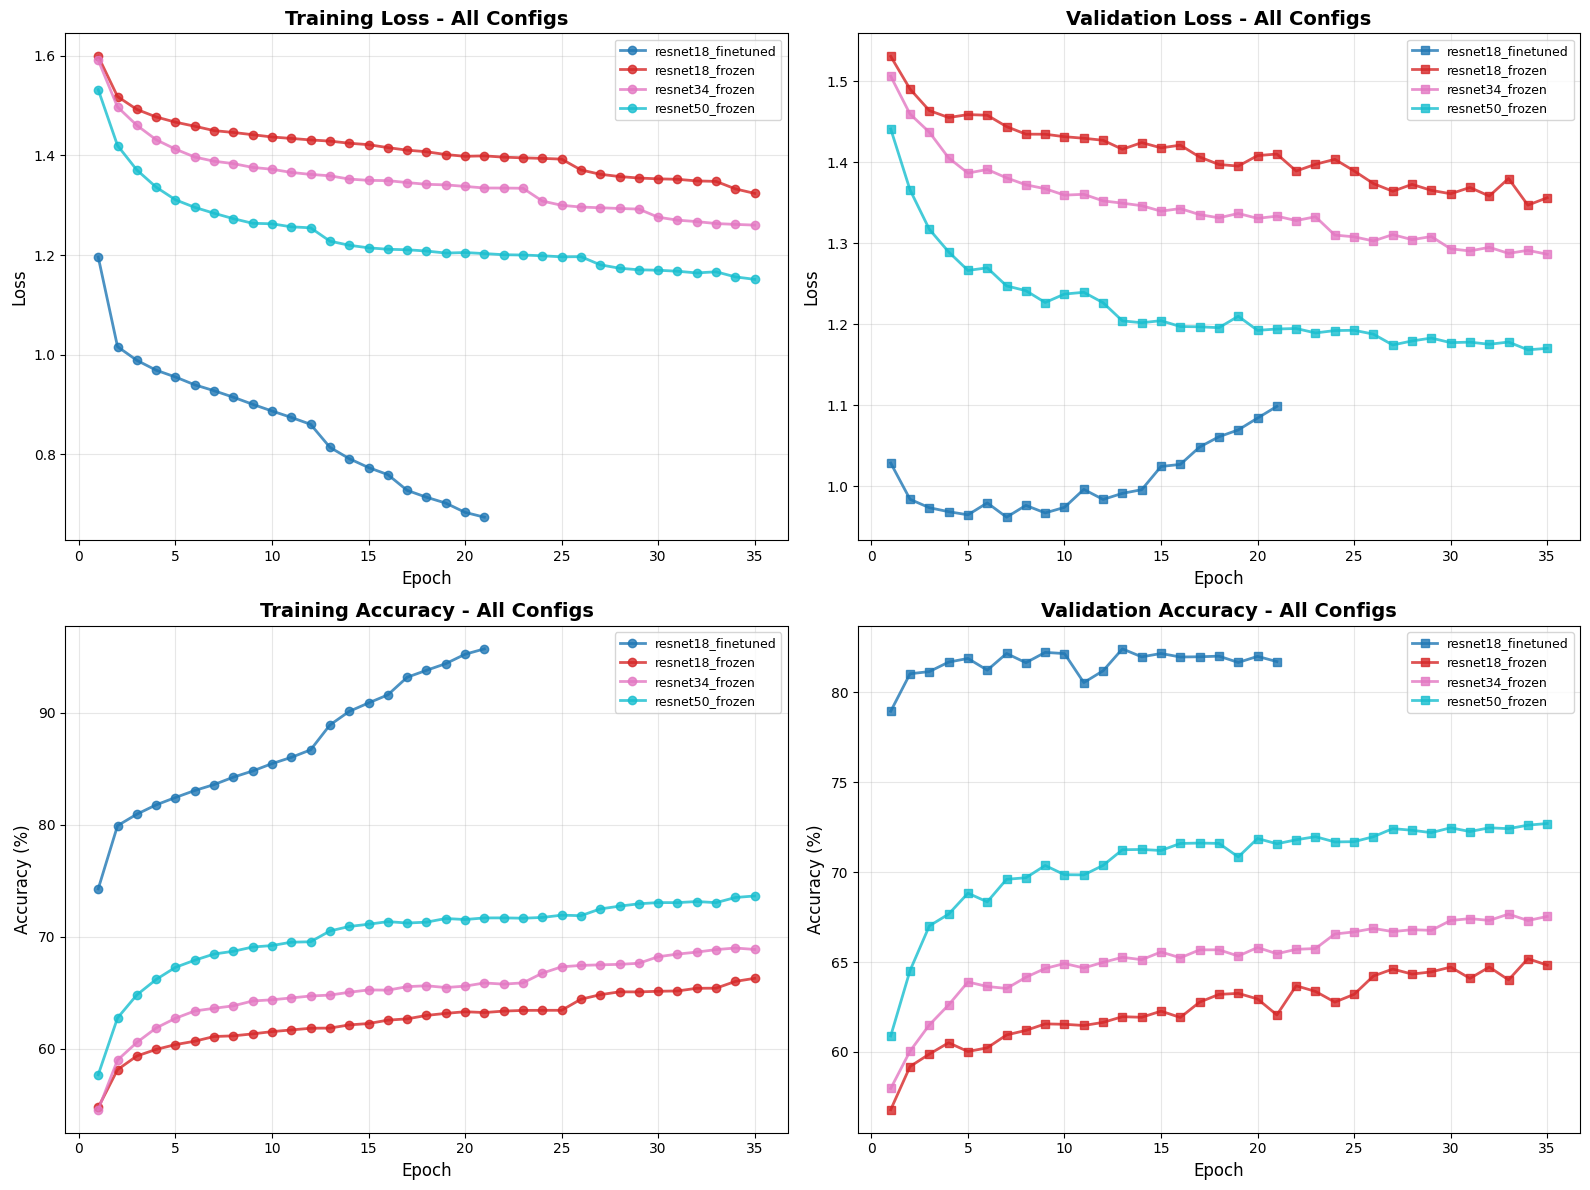

Grafico confronto finale salvato: ./checkpoints/Transfer_learning_celeba_CNN/final_comparison.png


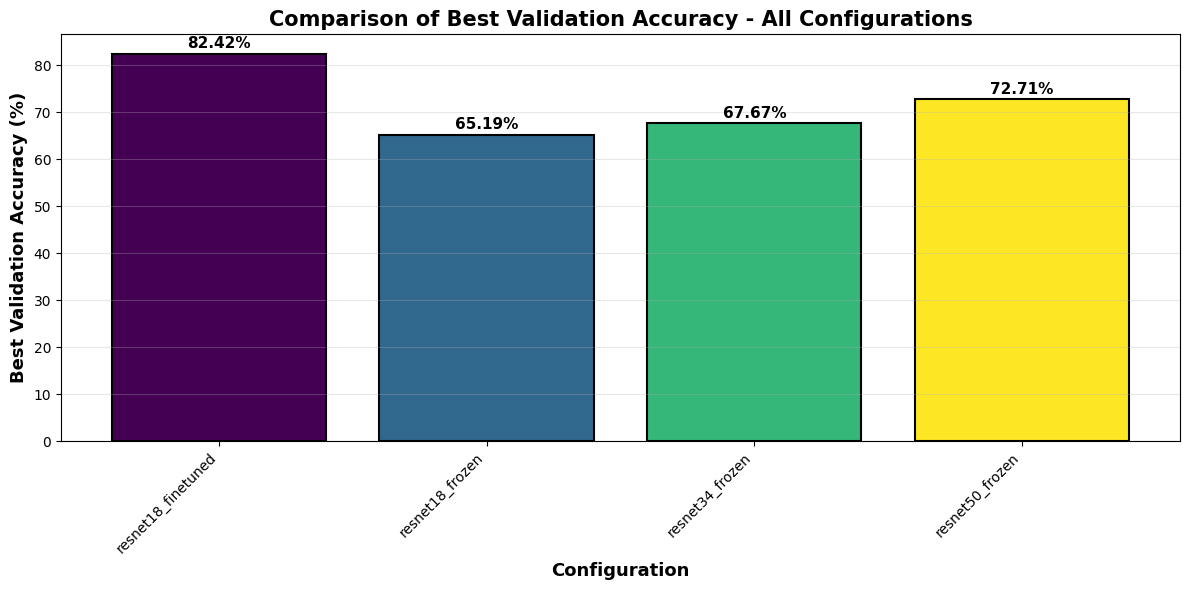

In [26]:
plot_all_histories(
        checkpoint_dir='./checkpoints/Transfer_learning_celeba_CNN',
        save_path='./checkpoints/Transfer_learning_celeba_CNN/all_histories_comparison.png'
    )

# Plotta bar chart con best accuracies
plot_final_comparison(
    checkpoint_dir='./checkpoints/Transfer_learning_celeba_CNN',
    save_path='./checkpoints/Transfer_learning_celeba_CNN/final_comparison.png'
)

In [28]:
print_models_summary(
    model_class=create_cnn_model,
    checkpoint_dir='./checkpoints/Transfer_learning_celeba_CNN'
)


SUMMARY - All Trained Models
Config               |      Parameters |  Best Val Acc |  Epochs
------------------------------------------------------------------------------------------


/root/Git/Progetto_DeepLearning_e_architetture_di_Reti_Neurali/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/Git/Progetto_DeepLearning_e_architetture_di_Reti_Neurali/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


resnet18_finetuned   |      15,200,693 |        82.42% |      21
resnet18_frozen      |           ERROR |             - |       -
resnet34_frozen      |           ERROR |             - |       -
resnet50_frozen      |           ERROR |             - |       -

Best Model: resnet18_finetuned with 82.42% accuracy
   Parameters: 15,200,693
   Epochs trained: 21


Grafico overfitting salvato: ./checkpoints/Transfer_learning_celeba_CNN/overfitting_analysis.png


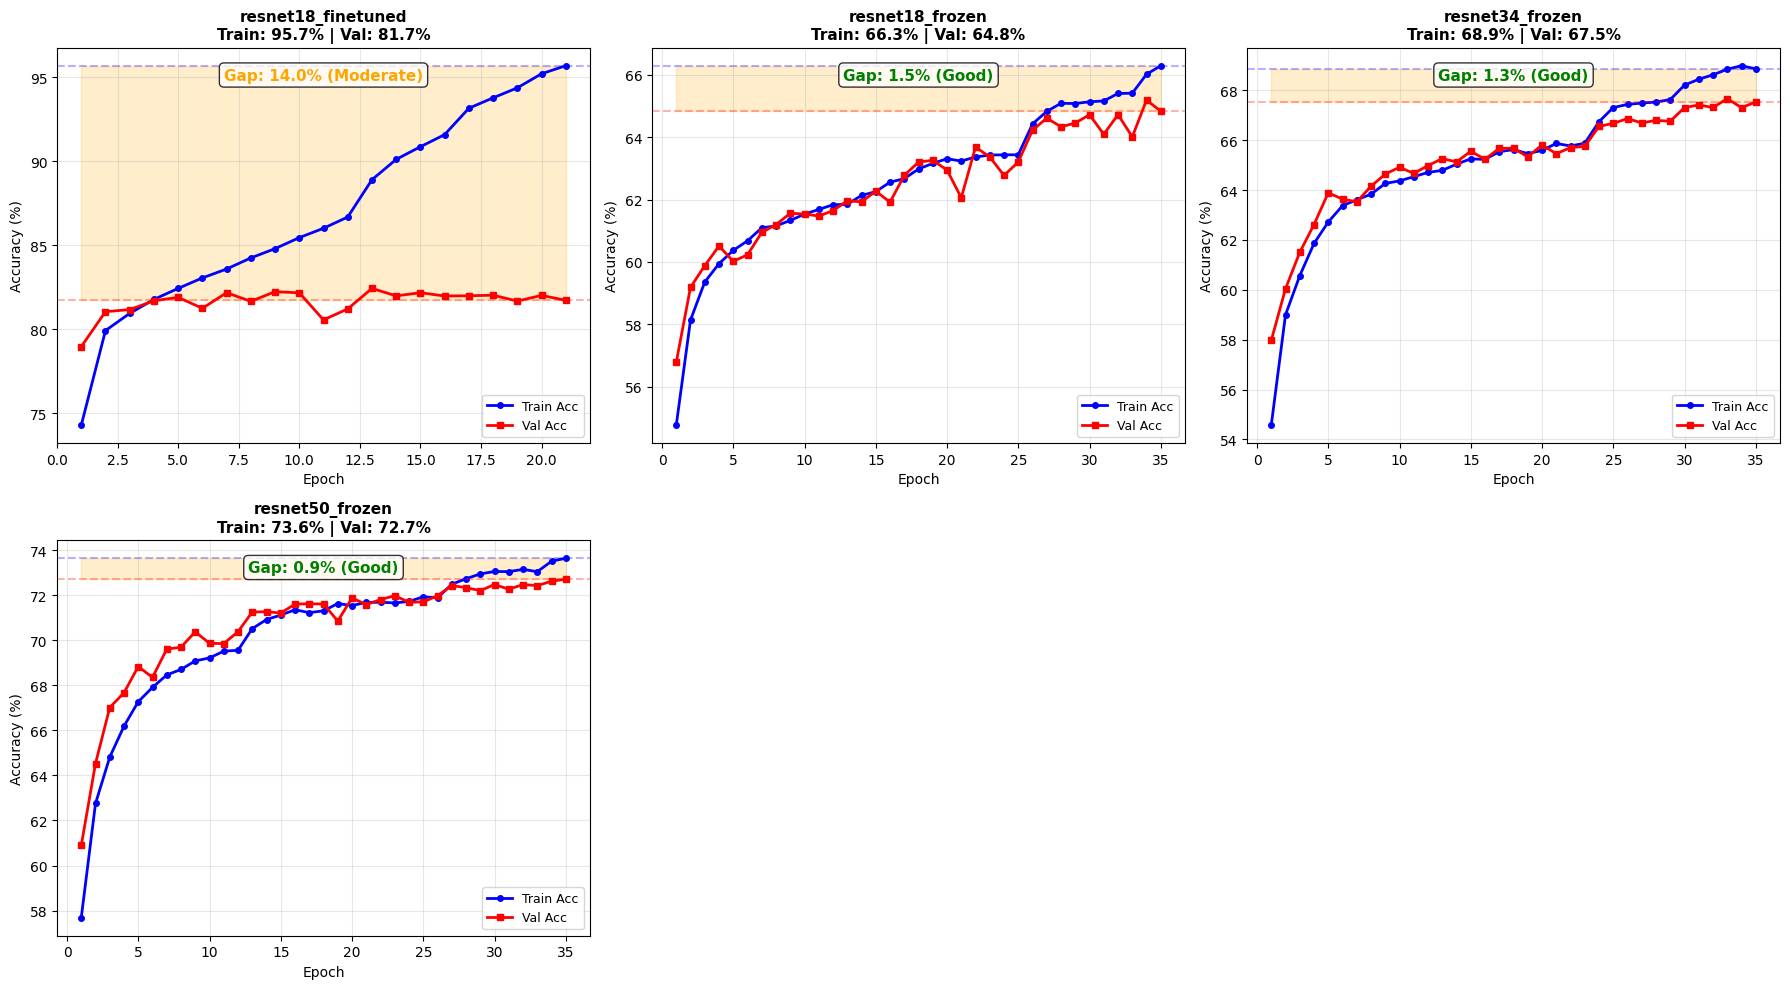


OVERFITTING ANALYSIS
Config                    |  Train Acc |    Val Acc |        Gap | Status         
--------------------------------------------------------------------------------
resnet18_finetuned        |     95.69% |     81.72% |     13.97% | Moderate       
resnet18_frozen           |     66.29% |     64.83% |      1.46% | Good           
resnet34_frozen           |     68.87% |     67.54% |      1.33% | Good           
resnet50_frozen           |     73.64% |     72.71% |      0.93% | Good           
Note: Gap = Train Acc - Val Acc
  Gap > 15% = Severe overfitting
  Gap 5-15% = Moderate overfitting
  Gap < 5%  = Good generalization



In [29]:
plot_overfitting_analysis(
    checkpoint_dir='./checkpoints/Transfer_learning_celeba_CNN',
    save_path='./checkpoints/Transfer_learning_celeba_CNN/overfitting_analysis.png'
)